# Classifiers using neuro-imaging data

In [1]:
import pandas as pd
import numpy as np
from numpy import random, arange
import seaborn as sns
import patsy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, PolynomialFeatures, LabelEncoder, RobustScaler

# Import relevant sklearn classes related to machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, ElasticNet
from sklearn.svm import SVC, SVR, NuSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay

# Import relevant sklearn class/function related to evaluation
import sklearn.metrics
from imblearn.under_sampling import RandomUnderSampler

#Smote oversampling 
import smote_variants as sv

#Harmonisation methods
from neuroCombat import neuroCombat #ComBat
from combat.pycombat import pycombat
import covbat #CovBat
from neuroHarmonize import harmonizationApply, harmonizationLearn #ComBat-GAM

# Alzheimer's diagnosis classifier

Here, we wish to creater a classifier that is able to distinguish patients which have dementia/alzheimer's from patients that either have MCI or do not have any problem.
This classifier uses cross sectional brain imaging data.

## Data Pre-Processing

In [2]:
# Import Datasets
img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
demographics = pd.read_csv("../data/PTDEMOG.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [3]:
# Select baseline scans, and harmonise naming convention
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)
adni2 = img_adni2.loc[img_adni2['VISCODE2'] == "sc"]
adni3 = img_adni3.loc[img_adni3['VISCODE2'] == "sc"]
adni1 = img_adni1.loc[img_adni1['VISCODE'] == 'bl']

In [4]:
# Select interesting columns (ROIs and quality metrics)

# Quality Metrics
QMs = []
# Cortical thickness averages
TAs = []


for col in adni2.columns:
    
    if col.endswith('QC'):
        QMs.append(col)
    
    
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
TAs2.append("VISCODE")
QMs = QMs[:-2]
TAs.append("VISCODE2")


In [5]:
# Merge imaging dataset with diagnosis dataset for the 3 adni phases

dxbl_subset = dx.loc[:,["VISCODE", "VISCODE2", "RID", "DXCHANGE","DXCURREN","DIAGNOSIS", "PTID", "SITEID", "USERDATE"]].copy()
dxbl_subset["USERDATE"] = pd.to_datetime(dxbl_subset["USERDATE"])
dxbl_subset["USERDATE"] = pd.DatetimeIndex(dxbl_subset["USERDATE"]).year

imgdx2 = pd.merge(adni2.loc[:,TAs+QMs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx3 = pd.merge(adni3.loc[:,TAs+QMs].copy(), dxbl_subset, on=["RID", "VISCODE2"])
imgdx1 = pd.merge(adni1.loc[:,TAs2+QMs].copy(), dxbl_subset, on=["RID", "VISCODE"])

In [6]:
# Harmonise diagnosis naming convention between adni phases
imgdx2.loc[(imgdx2["DXCHANGE"] == 1) | (imgdx2["DXCHANGE"] == 4) |(imgdx2["DXCHANGE"] == 6), 'DXCHANGE'] = 1
imgdx2.loc[(imgdx2["DXCHANGE"] == 2) | (imgdx2["DXCHANGE"] == 5) |(imgdx2["DXCHANGE"] == 7), 'DXCHANGE'] = 2
imgdx2.loc[(imgdx2["DXCHANGE"] == 3) | (imgdx2["DXCHANGE"] == 8) |(imgdx2["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [7]:
# Append phases together
img = imgdx1.append(imgdx2.append(imgdx3))

In [8]:
#Simplify QC naming
for qm in QMs:
    
    img.loc[img[qm] == "Fail",qm] = -1
    img.loc[img[qm] == "Partial",qm] = 0
    img.loc[img[qm] == "Pass",qm] = 1
    img.loc[(img[qm] != 0) & (img[qm] != 1) & (img[qm] != -1),qm] = 0

In [9]:
# Get covariates
img_cov = pd.merge(img, demographics.loc[:,["RID", "VISCODE2", "PTGENDER", "PTHAND", "PTDOBYY"]], on=["RID", "VISCODE2"])

In [10]:
#Add age column
img_cov["AGE"] = img_cov["USERDATE"] - img_cov["PTDOBYY"]


In [11]:
# Merge diagnoses together between phases
img_cov['DIAGNOSIS'] = img_cov['DIAGNOSIS'].fillna(img_cov['DXCHANGE'])
img_cov['DIAGNOSIS'] = img_cov['DIAGNOSIS'].fillna(img_cov['DXCURREN'])
img_cov.drop(['DXCURREN', 'DXCHANGE'], axis=1, inplace=True)

In [12]:
# Drop rows with nan values
img_cov.dropna(inplace=True)

In [13]:
# Only select one visit per patient
img_cov = img_cov.drop_duplicates("PTID")

In [14]:
img = img_cov

### Data visualisation: Show patient distribution

<ipython-input-19-2e2de0f2d05d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 1] = 'CN'


Males: 664 ->47.942238267148014%
Females: 721 ->52.05776173285198%


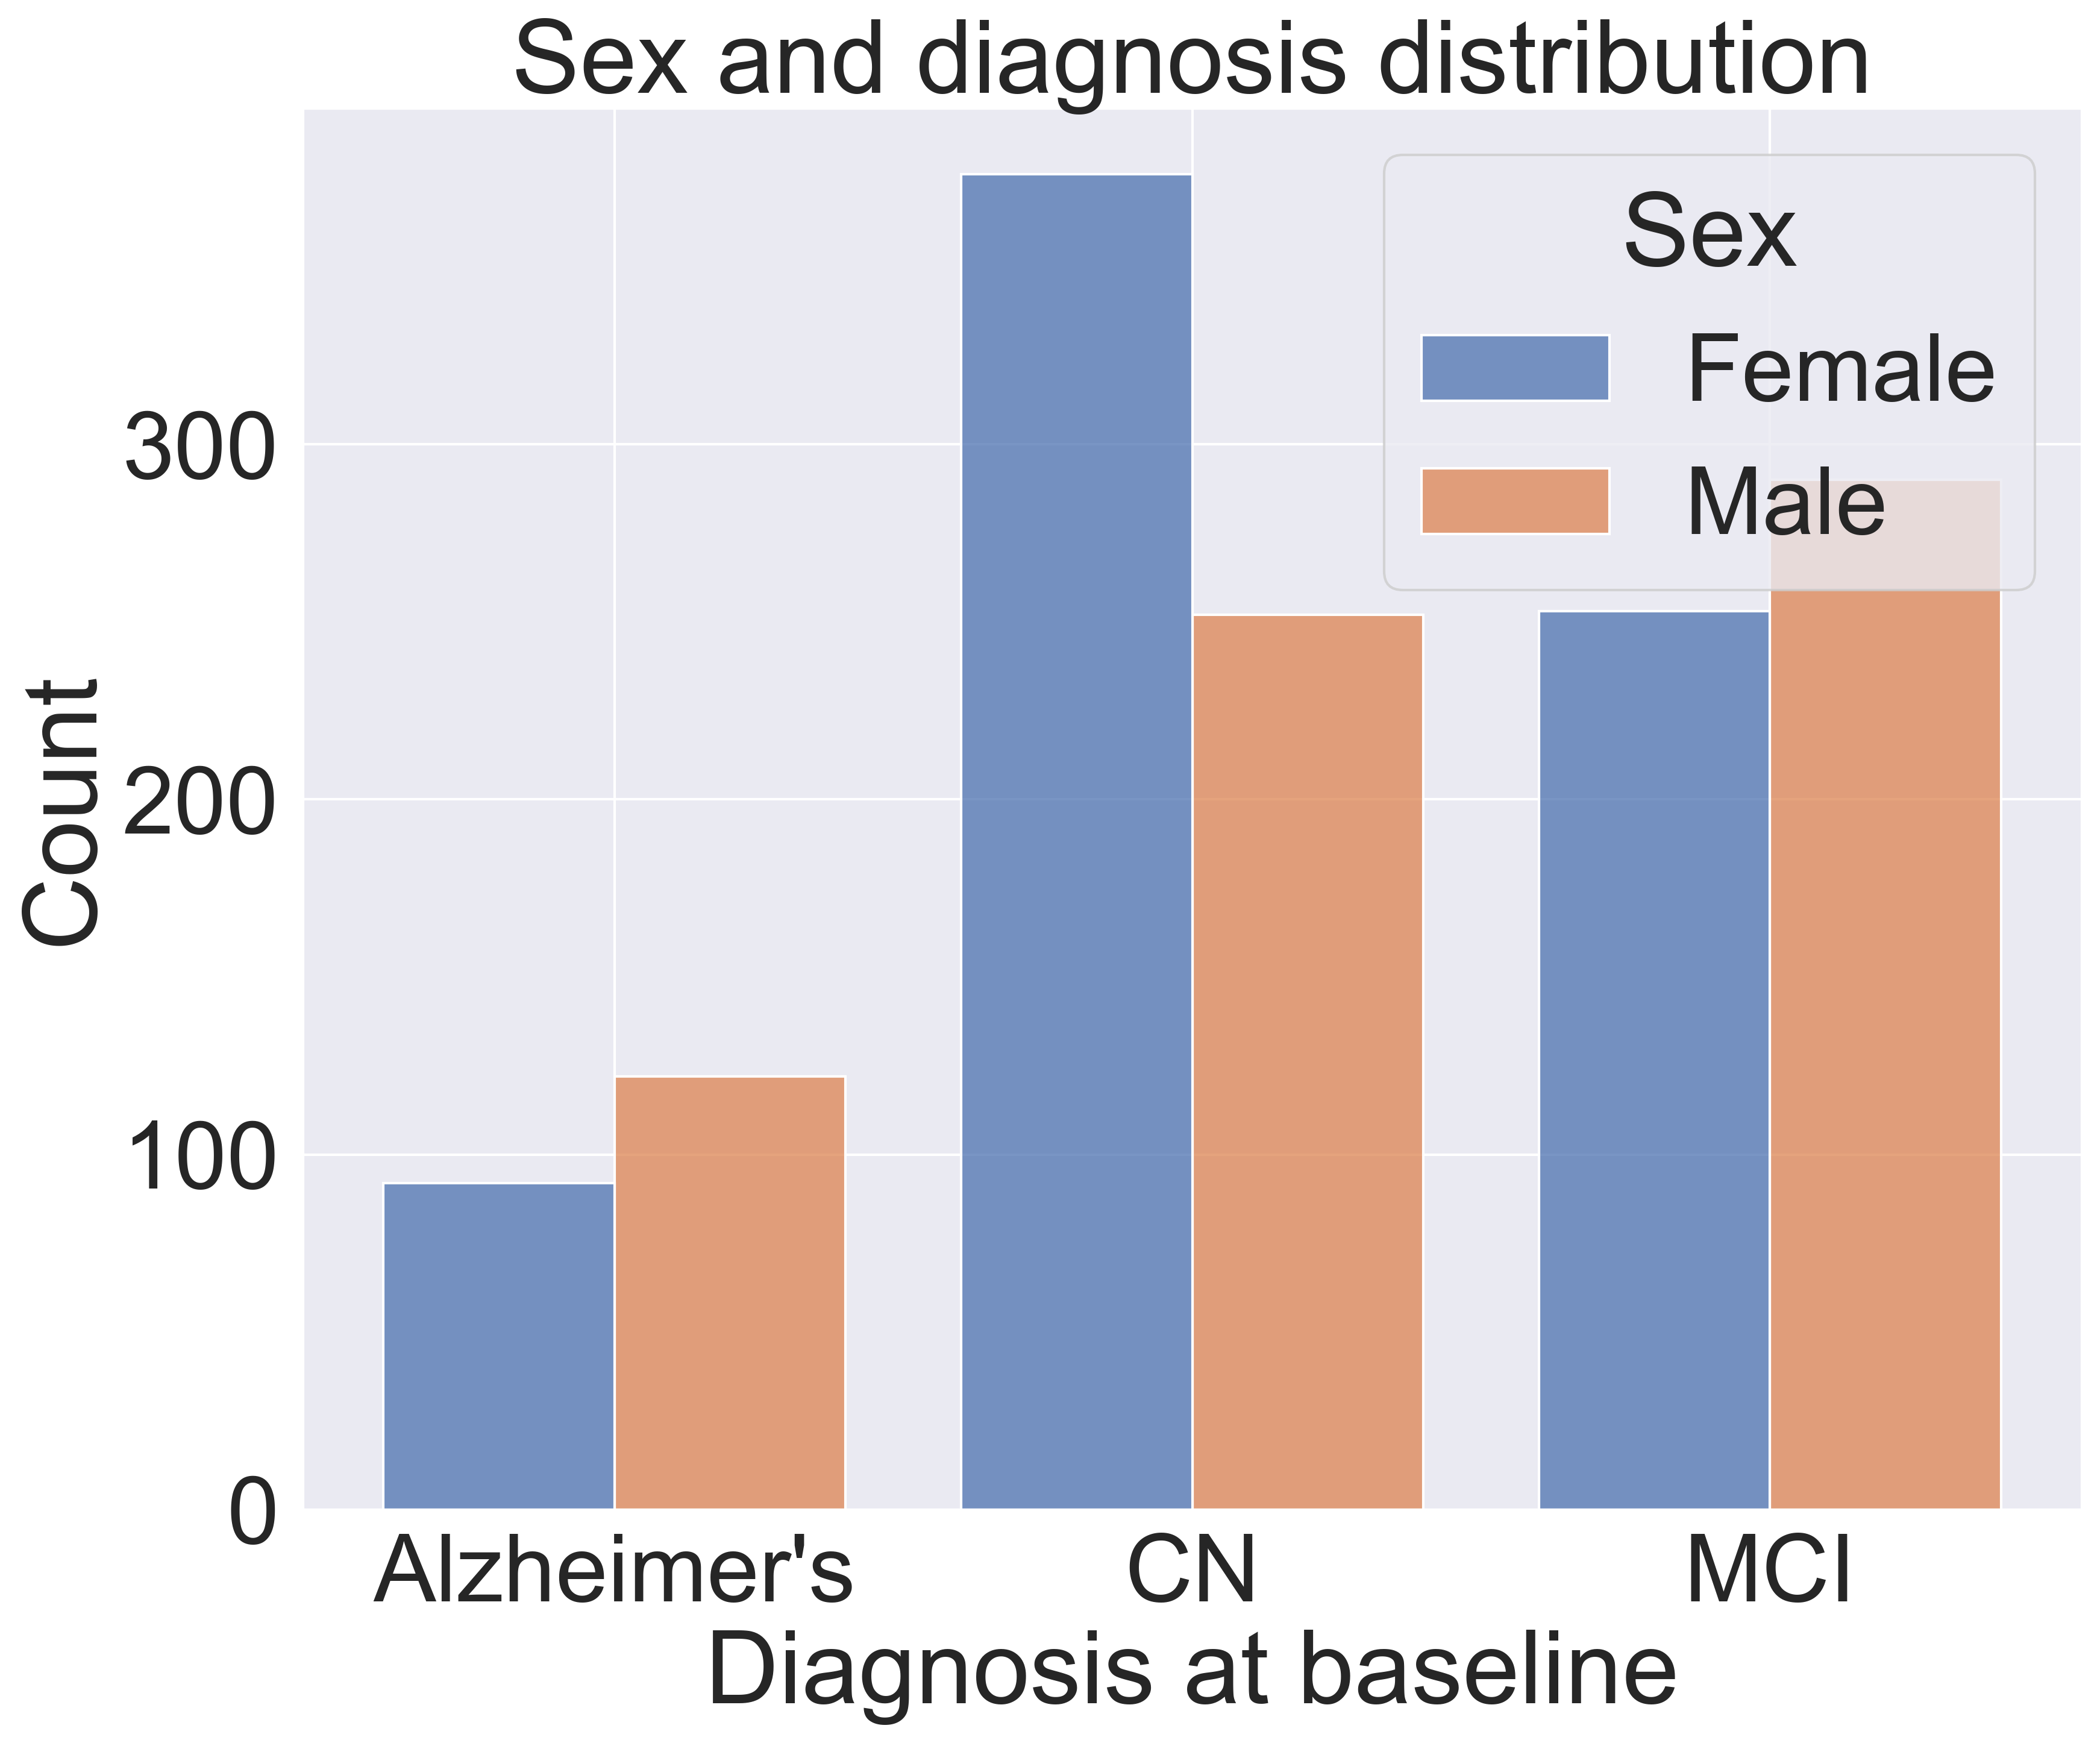

In [19]:
#Sex, Age, and diagnosis distrib
dems = img_cov.copy()
sex = dems['PTGENDER'].copy()
sex[sex==1] = "Male"
sex[sex==2] = "Female"
dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 1] = 'CN'
dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 2] = 'MCI'
dems['DIAGNOSIS'][dems['DIAGNOSIS'] == 3] = 'Alzheimer\'s'
males = len(sex[sex=="Male"])
females = len(sex[sex=="Female"])
total = (len(sex))
dems['Sex'] = sex

#Plot
sns.set_style("dark")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set(rc={'figure.figsize':(12.7,10.27)})
sns.set(font_scale=3.4)
hist_plot = sns.histplot(data=dems, x="DIAGNOSIS", hue="Sex", multiple="dodge", shrink=.8).set(title='Sex and diagnosis distribution', xlabel='Diagnosis at baseline')[0]
fig = hist_plot.get_figure()
fig.savefig("sexdiag.png") 

print("Males: " + str(males) + " ->" + str(males / total *100)+ "%")
print("Females: " + str(females) + " ->" + str(females / total *100)+ "%")

In [16]:
diag = img_cov["DIAGNOSIS"]
print("SANE: " + str(len(diag[diag==1])))
print("MCI: " + str(len(diag[diag==2])))
print("AD: " + str(len(diag[diag==3])))

SANE: 628
MCI: 543
AD: 214


In [17]:
img_cov.describe()

,ST102TA,ST103TA,ST104TA,ST105TA,ST106TA,ST107TA,ST108TA,ST109TA,ST110TA,ST111TA,...,ST98TA,ST99TA,RID,DIAGNOSIS,SITEID,USERDATE,PTGENDER,PTHAND,PTDOBYY,AGE
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,2.278358,2.681552,2.458812,2.596168,2.326003,1.557303,1.906316,2.420336,2.344900,2.272723,...,2.365835,2.795666,5380.818051,1.701083,31.321300,2014.499639,1.520578,1.098917,1942.664260,71.835379
std,0.178284,0.305840,0.160530,0.221359,0.158360,0.146858,0.148441,0.191241,0.177477,0.167551,...,0.186658,0.189568,971.739976,0.720393,18.158861,3.364883,0.499757,0.298658,8.497317,7.329392
min,1.611000,1.573000,1.782000,1.694000,1.779000,1.171000,1.482000,1.118000,1.650000,1.564000,...,1.784000,1.696000,4001.000000,1.000000,1.000000,2011.000000,1.000000,1.000000,1920.000000,50.000000
25%,2.168000,2.492000,2.350000,2.448000,2.223000,1.452000,1.811000,2.303000,2.241000,2.172000,...,2.235000,2.697000,4509.000000,1.000000,16.000000,2012.000000,1.000000,1.000000,1937.000000,67.000000
50%,2.284000,2.694000,2.468000,2.589000,2.330000,1.544000,1.906000,2.415000,2.361000,2.277000,...,2.359000,2.814000,5090.000000,2.000000,31.000000,2013.000000,2.000000,1.000000,1943.000000,72.000000
75%,2.396000,2.895000,2.572000,2.750000,2.427000,1.656000,2.001000,2.534000,2.465000,2.390000,...,2.497000,2.921000,6369.000000,2.000000,47.000000,2018.000000,2.000000,1.000000,1948.000000,77.000000
max,2.906000,3.505000,2.951000,3.512000,2.853000,2.127000,2.630000,3.098000,2.804000,2.846000,...,2.891000,3.258000,7066.000000,3.000000,63.000000,2022.000000,2.000000,2.000000,1971.000000,91.000000


In [18]:
# Get the number of sites
img_cov['SITEID'].nunique()

62

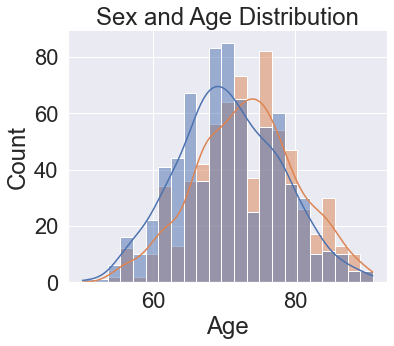

In [18]:
dems = img_cov.copy()
sex = dems['PTGENDER'].copy()
sex[sex==1] = "Male"
sex[sex==2] = "Female"
dems['Sex'] = sex
sns.set(font_scale=2)
dist_plot = sns.displot(data=dems, x='AGE', hue="Sex", kde=True, aspect=1.2, legend=False).set(title='Sex and Age Distribution', xlabel='Age')
fig = dist_plot.fig
fig.savefig("sexage.png") 

### Data visualisation: Cortical thickness difference between sane and alzheimer's patients

In [158]:
from utils import DKDict
import ggseg

In [159]:
sane = img[img['DIAGNOSIS'] == 1]
alz = img[img['DIAGNOSIS'] == 3]

In [171]:
diff = ((sane.mean() - alz.mean())/ sane.mean() * 100).to_numpy()


In [172]:
atlasDict = DKDict()

In [173]:
atlasDict.toDKName('ST102TA')

'paracentral_right'

In [174]:
diffs_df = pd.DataFrame(columns=TAs[:-2])

In [175]:
regions_diff = {}
diffs = []
reg = []
for i in range(68):
    region = atlasDict.toDKName(img.columns[i])
    regions_diff[region] =  diff[i]
    diffs.append(diff[i])
    reg.append(region)
    


In [176]:
diffs_df = pd.DataFrame()
diffs_df['region'] = reg
diffs_df['diff'] = diffs

In [177]:
reg[np.argmax([diffs])]

'entorhinal_right'

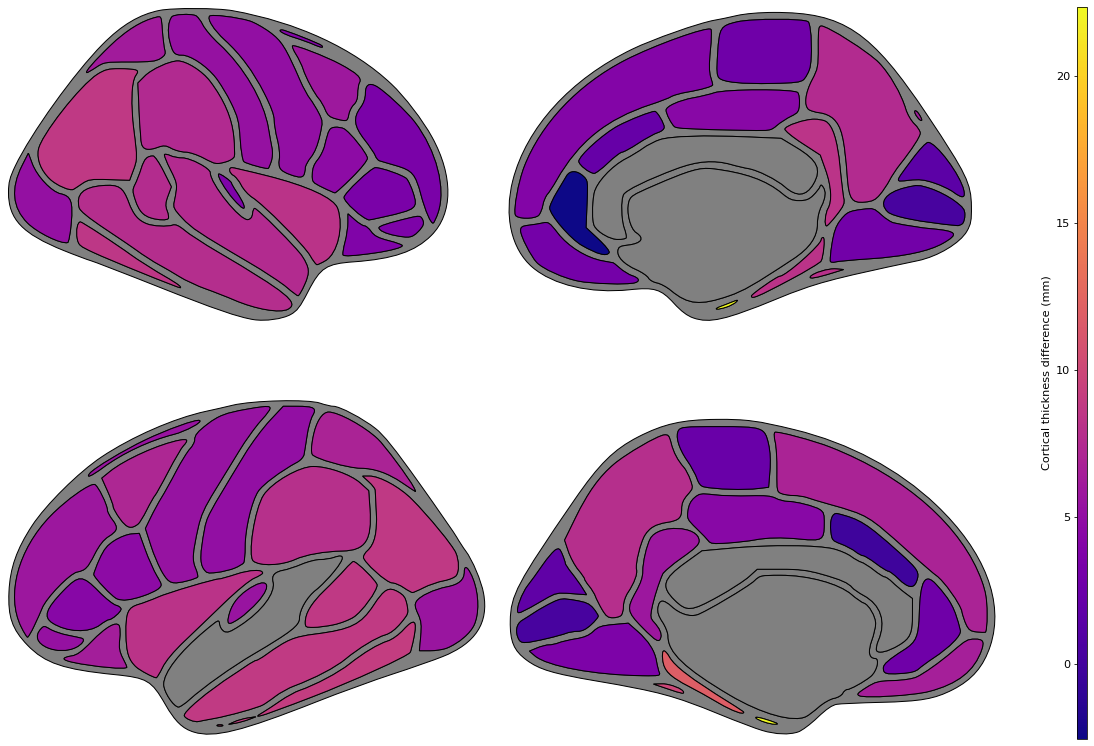

In [181]:
ggseg.plot_dk(regions_diff, background='w', edgecolor='k', cmap='plasma', 
              bordercolor='gray', ylabel='Cortical thickness difference (mm)', title='')

### Finish preparing data

In [42]:
img_sub = img[~(img["DIAGNOSIS"] == 2)]
img_sub.dropna(inplace=True)
Y = img_sub['DIAGNOSIS']
X = img_sub.drop(['DIAGNOSIS'], axis=1)
Y[Y == 1] = 0
Y[Y == 3] = 1


<ipython-input-42-fdb4994b7c0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_sub.dropna(inplace=True)
<ipython-input-42-fdb4994b7c0e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y == 1] = 0
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-42-fdb4994b7c0e>:6: SettingWithCopyWarning: 


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, train_size=0.6)

In [44]:
covs = X_train.loc[:,["AGE", "PTGENDER", "PTHAND"]].copy()
covs_test = X_test.loc[:,["AGE", "PTGENDER", "PTHAND"]].copy()
quality_metrics_train = X_train.loc[:, QMs].copy()
quality_metrics_test = X_test.loc[:,QMs].copy()

In [45]:
X_test = X_test.drop(["VISCODE", "VISCODE2", "PTID", "RID", "PTHAND", "AGE", "PTGENDER", "PTDOBYY", "USERDATE"] + QMs, axis=1)
X_train = X_train.drop(["VISCODE", "VISCODE2", "PTID", "RID", "PTHAND", "AGE", "PTGENDER", "PTDOBYY", "USERDATE"] + QMs, axis=1)

## Harmonisation

### ComBat harmonisation

In [46]:
# Only get sites with 2 visits or more
v = X_train.SITEID.value_counts()
X_train_pre_com = X_train.copy()[X_train.SITEID.isin(v.index[v.gt(1)])]

In [47]:
covs_combat = covs.copy().loc[X_train_pre_com.index]
covs_combat['batch'] = X_train_pre_com['SITEID']
categorical_cols = ['PTGENDER']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'
X_train_pre_com.drop('SITEID', inplace=True, axis=1)
#Harmonization step:
data_combat = neuroCombat(dat=X_train_pre_com.T,
    covars=covs_combat,
    batch_col=batch_col,
    categorical_cols=categorical_cols)["data"]


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [48]:
X_train_com = pd.DataFrame(data_combat.T).set_axis(X_train.columns[:-1], axis=1, inplace=False)

### CovBat

In [49]:
#Only get scanners with more than 1 visit
v = X_train.SITEID.value_counts()
X_train_pre_cov = X_train.copy()[X_train.SITEID.isin(v.index[v.gt(1)])]

In [50]:
covs_covbat = covs.copy().loc[X_train_pre_cov.index]
covs_covbat['batch'] = X_train_pre_cov['SITEID']
covs_covbat['outcome'] = y_train

X_train_pre_cov.drop(['SITEID'], inplace=True, axis=1)
mod = patsy.dmatrix("~ AGE + outcome", covs_covbat, return_type="dataframe")

In [51]:
X_train_cov = covbat.covbat(X_train_pre_cov.T, covs_covbat['batch'], covs_covbat, "AGE")

found 60 batches
found 1 numerical covariates...
	AGE
found 3 categorical variables:	PTGENDER, PTHAND, outcome
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


found 60 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


### ComBat-GAM

In [26]:
#Only get scanners with more than 1 visit
v = X_train.SITEID.value_counts()
X_train_pre_cbg = X_train.copy()[X_train.SITEID.isin(v.index[v.gt(1)])]

In [27]:
covs_cbg = covs.copy().loc[X_train_pre_cbg.index]
covs_cbg['SITE'] = X_train_pre_cbg['SITEID']
covs_cbg['outcome'] = y_train.loc[X_train_pre_cbg.index]

X_train_pre_cbg.drop(['SITEID'], inplace=True, axis=1)
my_model, my_data_adj = harmonizationLearn(X_train_pre_cbg.to_numpy(), covs_cbg, smooth_terms=['AGE'])


[neuroHarmonize]: smoothing more than 10 variables may take several minutes of computation.


In [28]:
X_train_cbg = pd.DataFrame(my_data_adj).set_axis(X_train.columns[:-1], axis=1, inplace=False)

### NeuroHarmony

In [59]:
from neuroharmony import exclude_single_subject_groups, fetch_sample, Neuroharmony
from neuroharmony.data.rois import rois

covs2 = covs.copy()
covs2['batch'] = X_train['SITEID']

X_train_nh = X_train.copy()
X_train_nh["PTGENDER"] = covs2['PTGENDER']
X_train_nh['PTHAND'] = covs2['PTHAND']
X_train_nh['AGE'] = covs2['AGE']
X_train_nh['scanner'] = covs2['batch']
X_train_nh.drop("SITEID", inplace=True, axis=1)
X_train_nh['DIAGNOSIS'] = y_train

for qm in QMs:
    X_train_nh[qm] = quality_metrics_train[qm]
    
features = TAs[:-2]
covariates = ["PTGENDER", "PTHAND", "scanner", 'AGE'] #  "AGE"
exclude_vars = X_train_nh.columns[X_train_nh.isna().sum() != 0].to_list() + ['Dataset', 'DIAGNOSIS']
regression_features = [var for var in X_train_nh.columns if var not in (covariates + features + exclude_vars)]

eliminate_variance = ["scanner"]

scanners = X_train_nh['scanner'].unique()
n_scanners = len(scanners)


In [60]:
#Split train and test leaving one scanner out.

X_train_nh.AGE = X_train_nh.AGE.astype(int)
train_bool = X_train_nh['scanner'].isin(scanners[1:])
test_bool = X_train_nh['scanner'].isin(scanners[:1])
X_train_split = X_train_nh[train_bool]
X_test_split = X_train_nh[test_bool]
x_train, x_test = X_train_split, X_test_split
x_train = exclude_single_subject_groups(X_train_nh, covariates)

# Create the Neuroharmony model.
# Here you can establish the range of the hyperparameters via random search or give specific values.
harmony = Neuroharmony(
    features,
    regression_features,
    covariates,
    eliminate_variance,
    param_distributions=dict(
        RandomForestRegressor__n_estimators=[100, 200, 500],
        RandomForestRegressor__random_state=[42, 78],
        RandomForestRegressor__warm_start=[False, True],
    ),
    estimator_args=dict(n_jobs=1, random_state=42),
    randomized_search_args=dict(cv=5, n_jobs=8),
)
# Fit the model.
x_train_harmonized = harmony.fit_transform(x_train)

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\neuroharmony\models\neuroCombat.py:228: RuntimeWarning: divide by zero encountered in divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())
Randomized search of Neuroharmony hyperparameters: 100%|██████████| 68/68 [14:07<00:00, 12.46s/it]


## Train, cross-validate & evaluate models

In [61]:
def find_oversampler(X, y):

    dataset= {'data': np.array(X),
            'target': np.array(y),
            'name': 'diagnosis'}

    classifiers = [('sklearn.ensemble', 'GradientBoostingClassifier', {}),
                ('sklearn.ensemble', 'RandomForestClassifier', {}),
                ('sklearn.neural_network', 'MLPClassifier', {}),
                ('sklearn.tree', 'DecisionTreeClassifier', {})]

    oversamplers = sv.queries.get_all_oversamplers(n_quickest=2)

    os_params = sv.queries.generate_parameter_combinations(oversamplers,
                                                        n_max_comb=2)

    # samp_obj and cl_obj contain the oversampling and classifier objects which give the
    # best performance together
    samp_obj, cl_obj= sv.evaluation.model_selection(dataset=dataset,
                                                    oversamplers=os_params,
                                                    classifiers=classifiers,
                                                    validator_params={'n_splits': 2,
                                                                    'n_repeats': 1},
                                                    n_jobs= 5)
    print(samp_obj)
    return samp_obj, cl_obj

def k_fold_choose_model(X, y): 
    models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]
    models_accuracy = []
    
    kfold = KFold(n_splits=10)
    for model in models:
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
        models_accuracy.append(cv_results.sum()/10)
        print(model, cv_results.sum()/10)

    return models[np.argmax(np.array(models_accuracy))]


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    results = model.predict(X_test)
    x = zip(results, y_test)
    cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
    print(accuracy_score(y_test, results))
    print(balanced_accuracy_score(y_test, results))
    print(classification_report( y_test, results, output_dict=True))
    sns.heatmap(cf_matrix, annot=True, fmt='g')
    return model



In [53]:


def create_validate_model(X_train, y_train, undersample):
    #Use oversampling to tackle imbalance
    oversampler = find_oversampler(X_train, y_train)
    X_train_samp, y_train_samp = oversampler[0].sample(np.array(X_train),
                                np.array(y_train))
    # Now use undersampling
    if undersample:
        rus = RandomUnderSampler(random_state=0)
        X_train_samp, y_train_samp = rus.fit_resample(X_train_samp, y_train_samp)
    
    # Perform feature selection
    #X_train_resampled, cols, colNames = selectFeatures(X_train_resampled, y_train_resampled)

    # Find best model type
    model = k_fold_choose_model(X_train_samp, y_train_samp)
    print(model)
    return X_train_samp, y_train_samp

### Unharmonised

In [54]:
X_train.drop(['SITEID'], inplace=True, axis=1)
x_t_u, y_t_u = create_validate_model(X_train, y_train, True)

2023-04-20 11:41:09.818025: processing dataset: diagnosis


2023-04-20 11:41:33,006:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-04-20 11:41:33,011:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_bus', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
GradientBoostingClassifier() 0.8912100456621005
RandomForestClassifier() 0.8857115677321156
SVC() 0.893968797564688
DecisionTreeClassifier() 0.837576103500761
MLPClassifier() 0.8649543378995433
SVC()


In [55]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)
grid.fit(x_t_u, y_t_u)
print(grid.best_estimator_)

SVC(C=10, gamma=1)


In [56]:
X_test.drop(['SITEID'], inplace=True, axis=1)

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


0.8813056379821959
0.7677410901467505
{'0.0': {'precision': 0.89198606271777, 'recall': 0.9660377358490566, 'f1-score': 0.927536231884058, 'support': 265}, '1.0': {'precision': 0.82, 'recall': 0.5694444444444444, 'f1-score': 0.6721311475409835, 'support': 72}, 'accuracy': 0.8813056379821959, 'macro avg': {'precision': 0.855993031358885, 'recall': 0.7677410901467505, 'f1-score': 0.7998336897125207, 'support': 337}, 'weighted avg': {'precision': 0.8766062510985433, 'recall': 0.8813056379821959, 'f1-score': 0.8729689735080897, 'support': 337}}


SVC(C=10, gamma=1)

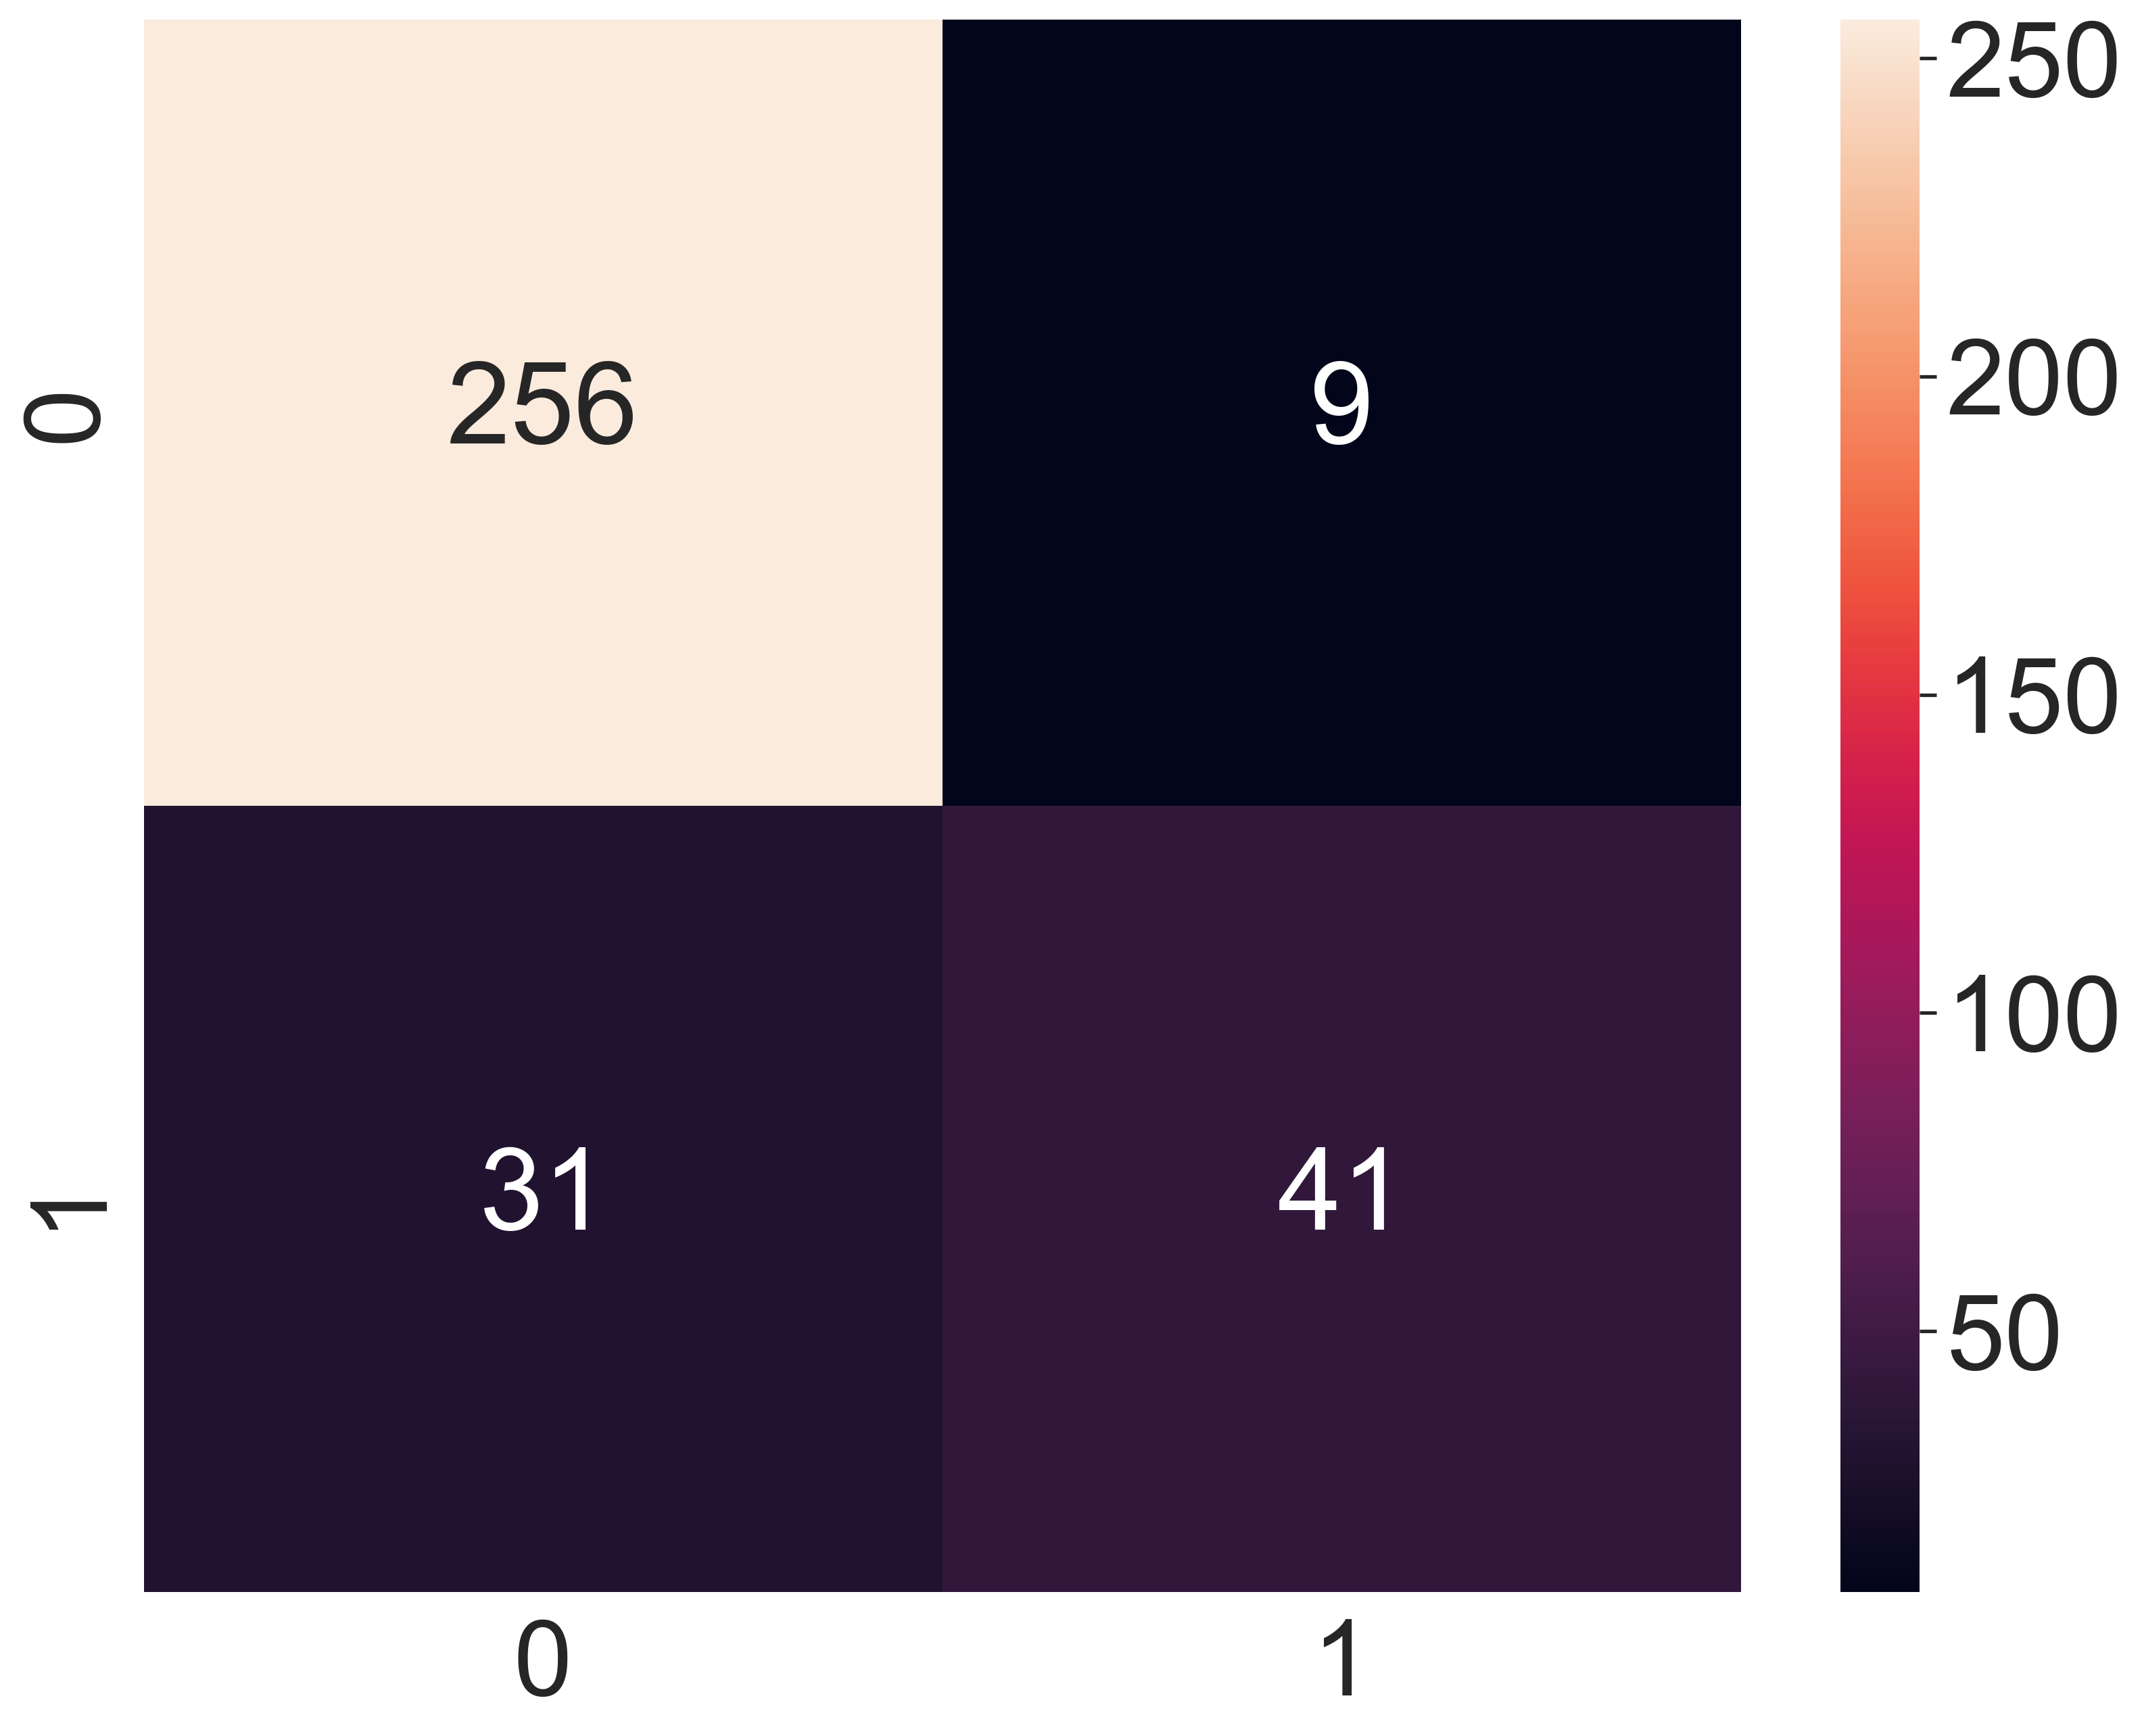

In [64]:
model = SVC(C=10, gamma=1)
evaluate_model(model, x_t_u, y_t_u, X_test, y_test)

### CovBat

In [36]:
x_t_cv, y_t_cv = create_validate_model(X_train_cov.T, y_train.loc[X_train_cov.T.index], True)

2023-04-17 09:43:11.539419: processing dataset: diagnosis


2023-04-17 09:43:24,404:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-04-17 09:43:24,406:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_bus', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
GradientBoostingClassifier() 0.9516552511415524
RandomForestClassifier() 0.9420471841704717
SVC() 0.9585426179604262
DecisionTreeClassifier() 0.9060502283105023
MLPClassifier() 0.9627092846270928
MLPClassifier()


In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=2)
grid.fit(x_t_cv, y_t_cv)
print(grid.best_estimator_)

0.8486646884272997
0.8370221327967806


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


MLPClassifier(activation='tanh')

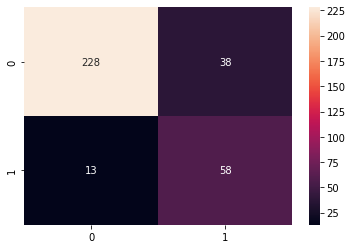

In [38]:
model_cov = MLPClassifier(activation='tanh')
evaluate_model(model_cov, x_t_cv, y_t_cv, X_test, y_test)

### ComBat

In [39]:
x_t_c, y_t_c = create_validate_model(X_train_com , y_train.loc[X_train_pre_com.index], True)

2023-04-17 09:54:05.639093: processing dataset: diagnosis


2023-04-17 09:54:20,660:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-04-17 09:54:20,661:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_star', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
GradientBoostingClassifier() 0.8881088280060883
RandomForestClassifier() 0.890810502283105
SVC() 0.8950152207001523
DecisionTreeClassifier() 0.8260654490106545
MLPClassifier() 0.8396879756468799
SVC()


In [40]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)
grid.fit(x_t_c, y_t_c)
print(grid.best_estimator_)

SVC(C=10, gamma=1)


0.8100890207715133
0.8280737053902361


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


MLPClassifier(activation='tanh')

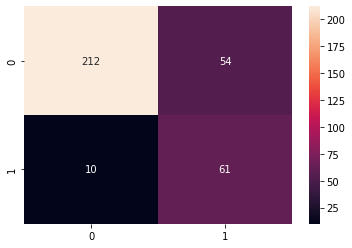

In [41]:
model_com = SVC(C=10, gamma=1)
evaluate_model(model_cov, x_t_c, y_t_c, X_test, y_test)

### ComBat-GAM

In [42]:
x_t_cg, y_t_cg = create_validate_model(X_train_cbg , y_train.loc[X_train_pre_cbg.index], True)

2023-04-17 09:58:04.676002: processing dataset: diagnosis


2023-04-17 09:58:17,904:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-04-17 09:58:17,906:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_bus', "{'proportion': 2.0, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
GradientBoostingClassifier() 0.9199200913242009
RandomForestClassifier() 0.9198630136986301
SVC() 0.9405631659056317
DecisionTreeClassifier() 0.8840563165905632
MLPClassifier() 0.9184360730593607
SVC()


In [43]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=0)
grid.fit(x_t_cg, y_t_cg)
print(grid.best_estimator_)

SVC(C=10, gamma=1)


0.8545994065281899
0.7168802287408662


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


SVC(C=10, gamma=1)

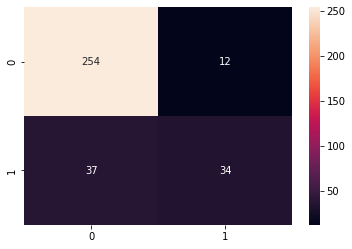

In [44]:
model_cg = SVC(C=10, gamma=1)
evaluate_model(model_cg, x_t_cg, y_t_cg, X_test, y_test)

### NeuroHarmony

In [121]:
y_train_nh = x_train_harmonized['DIAGNOSIS']
x_train_harmonized.drop('DIAGNOSIS', inplace=True, axis=1)

In [124]:
x_train_harmonized.drop(QMs+covariates, inplace=True, axis=1)

In [126]:
x_t, y_t = create_validate_model(x_train_harmonized, y_train_nh, True)

2023-04-16 23:34:01,907:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-04-16 23:34:01,909:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.5, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


In [ ]:
model_nh = SVC(C=10, gamma=1)
evaluate_model(model_nh, x_train_harmonized, y_train_nh, X_test, y_test)

### Analysis

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


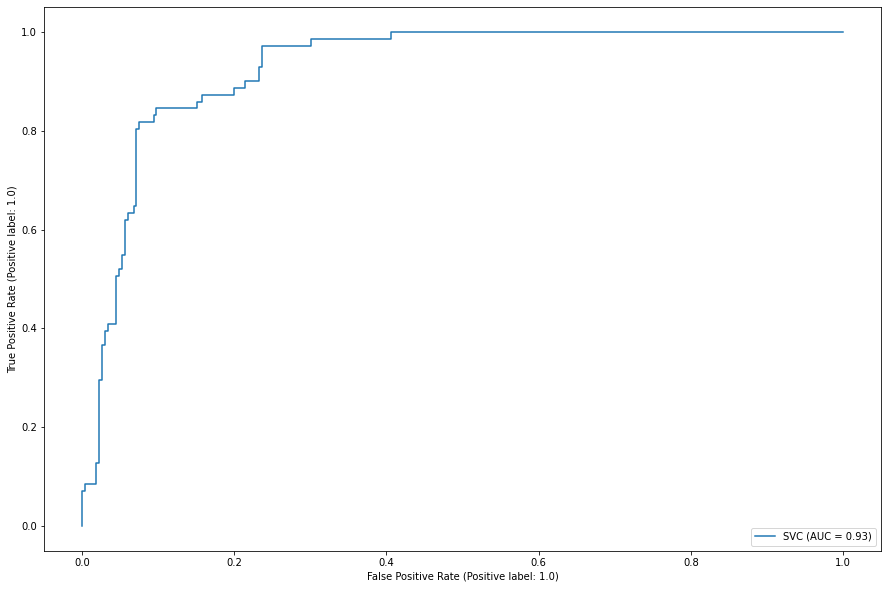

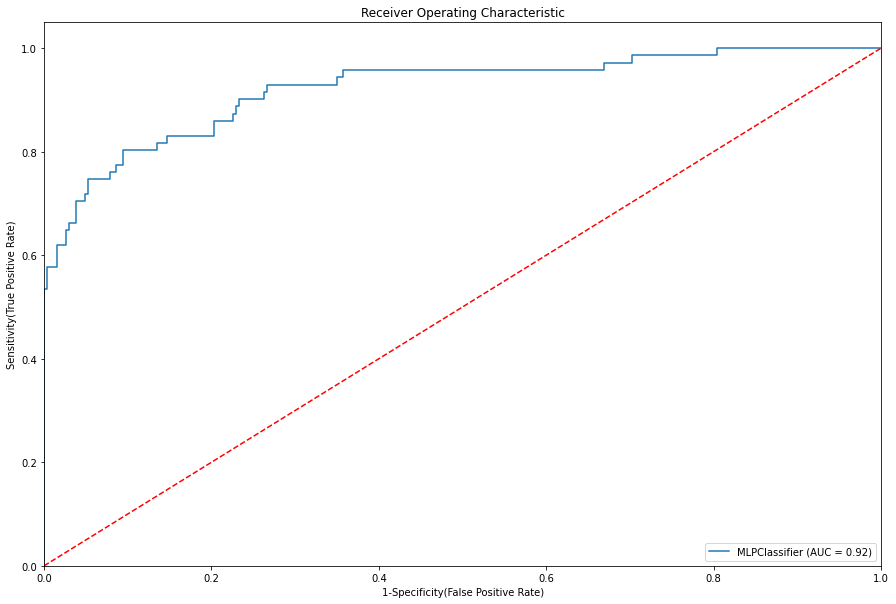

In [63]:

from sklearn.metrics import RocCurveDisplay
plt.rcParams['figure.figsize'] = [15, 10]
#models = [model, model_cov]
svc_disp1 = RocCurveDisplay.from_estimator(model, X_test, y_test)
svc_disp2 = RocCurveDisplay.from_estimator(model_cov, X_test, y_test)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

McNemar's Test

In [64]:
# McNemar's test
y_pred_unharm = model.predict(X_test)
y_pred_cov = model_cov.predict(X_test)

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [88]:
correct_cov = y_pred_cov == y_test
correct_uh = y_pred_unharm== y_test

both_correct = (correct_cov & correct_uh)
both_correct = len(both_correct[both_correct == True])

uh_correct = (correct_uh & ~correct_cov)
uh_correct = len(uh_correct[uh_correct == True])

cov_correct = (~correct_uh & correct_cov)
cov_correct = len(cov_correct[cov_correct == True])

none_correct = (~correct_uh & ~correct_cov)
none_correct = len(none_correct[none_correct == True])


data = [[both_correct, cov_correct],
         [uh_correct, none_correct]]

In [87]:
from statsmodels.stats.contingency_tables import mcnemar


threshold = 3.841 
significance_value = 0.05


# McNemar's Test with the continuity correction
test = mcnemar(data, exact=False, correction=True)

if test.pvalue < significance_value:
  print("Reject Null hypotesis")
else:
  print("Fail to reject Null hypotesis")


Reject Null hypotesis


# Evolution Predictor

Here we are trying to predict whether a patient currently experiencing MCI will get alzheimer's in the future from cross-sectionnal neuroimaging data. Researchers have found that having a MCI multiplies a patient's chances of developing Alzheimer's in the future. Around 20 to 20% of people with MCI develop dementia in under a year.
This is the reason why we are trying to predict the evolution. If we are able to detect whether a patient is very likely to get alzheimer's in under 2 years then it will be easier to help the patient.

## Data pre-processing

In [65]:
# Import datasets
img_adni1 = pd.read_csv("../data/UCSFFSX51_ADNI1_3T_02_01_16.csv", low_memory=False)
img_adni2 = pd.read_csv("../data/UCSFFSX51_11_08_19.csv", low_memory=False)
img_adni3 = pd.read_csv("../data/UCSFFSX6_08_17_22.csv", low_memory=False)
demographics = pd.read_csv("../data/PTDEMOG.csv", low_memory=False)
adni_merge= pd.read_csv('../data/ADNIMERGE.csv', low_memory=False)


In [66]:
# Harmonise nomenclature
img_adni2.replace("scmri", "sc", inplace=True)
dx = pd.read_csv("../data/DXSUM_PDXCONV_ADNIALL.csv", low_memory=False)

In [67]:

dx.loc[(dx["DXCHANGE"] == 1) | (dx["DXCHANGE"] == 4) |(dx["DXCHANGE"] == 6), 'DXCHANGE'] = 1
dx.loc[(dx["DXCHANGE"] == 2) | (dx["DXCHANGE"] == 5) |(dx["DXCHANGE"] == 7), 'DXCHANGE'] = 2
dx.loc[(dx["DXCHANGE"] == 3) | (dx["DXCHANGE"] == 8) |(dx["DXCHANGE"] == 9), 'DXCHANGE'] = 3


In [68]:
# Get Cortical thickness columns
TAs = []
QMs = []

for col in img_adni2.columns:
    
    if col.endswith('QC'):
        QMs.append(col)
    if col.endswith('TA'):
        TAs.append(col)

TAs.append("RID")
TAs2 = TAs.copy()
QMs = QMs[:-2]
TAs2.append("VISCODE2")
TAs.append("VISCODE")


In [69]:
img1 = img_adni1.loc[:,TAs + QMs].copy()
img2 = img_adni2.loc[:,TAs2 + QMs].copy()
img3 = img_adni3.loc[:,TAs2 + QMs].copy()

In [70]:
# Merge imaging and diagnosis
dx_info = dx.loc[:,["RID", "VISCODE", "VISCODE2", "PTID", "DXCURREN", "DXCHANGE", "DIAGNOSIS", "SITEID", "USERDATE"]].copy()
dx_info["USERDATE"] = pd.to_datetime(dx_info["USERDATE"])
dx_info["USERDATE"] = pd.DatetimeIndex(dx_info["USERDATE"]).year
img_dx_1 = pd.merge(img1, dx_info, on=['VISCODE', 'RID'])
img_dx_2 = pd.merge(img2, dx_info, on=['VISCODE2', 'RID'])
img_dx_3 = pd.merge(img3, dx_info, on=['VISCODE2', 'RID'])

In [71]:
# Get initial visits
init_1 = img_dx_1[img_dx_1['VISCODE'] == 'bl']
init_2 = img_dx_2[img_dx_2['VISCODE2'] == 'sc']
init_3 = img_dx_3[img_dx_3['VISCODE2'] == 'sc']

In [72]:
# Get visits at month 36
dx_m36 = dx.loc[(dx['VISCODE'] == "m36")|( dx['VISCODE2'] == "m36")]
dx_m36_diag = dx_m36.loc[:,["PTID", "DIAGNOSIS", "DXCHANGE", "DXCURREN"]]

In [73]:
dx_img1 = pd.merge(init_1, dx_m36_diag, on=["PTID"])
dx_img2 = pd.merge(init_2, dx_m36_diag, on=["PTID"])
dx_img3 = pd.merge(init_3, dx_m36_diag, on=["PTID"])

In [74]:
#Append phases together
dx_img = dx_img1[dx_img1['DXCURREN_x'] == 2].append(dx_img2[dx_img2['DXCHANGE_x'] == 2].append(dx_img3[dx_img3['DIAGNOSIS_x'] == 2]))

In [75]:
#Simplify QC naming
for qm in QMs:
    
    dx_img.loc[dx_img[qm] == "Fail",qm] = -1
    dx_img.loc[dx_img[qm] == "Partial",qm] = 0
    dx_img.loc[dx_img[qm] == "Pass",qm] = 1
    dx_img.loc[(dx_img[qm] != 0) & (dx_img[qm] != 1) & (dx_img[qm] != -1),qm] = 0

In [76]:
dx_img['DIAGNOSIS_x'] = dx_img['DIAGNOSIS_x'].fillna(dx_img['DXCHANGE_x'])
dx_img['DIAGNOSIS_x'] = dx_img['DIAGNOSIS_x'].fillna(dx_img['DXCURREN_x'])

dx_img['DIAGNOSIS_y'] = dx_img['DIAGNOSIS_y'].fillna(dx_img['DXCHANGE_y'])
dx_img['DIAGNOSIS_y'] = dx_img['DIAGNOSIS_y'].fillna(dx_img['DXCURREN_y'])



In [77]:
len(dx_img)

337

In [78]:
dx_img = pd.merge(dx_img, demographics.loc[:,["RID", "VISCODE2", "PTGENDER", "PTHAND", "PTDOBYY"]], on=["RID", "VISCODE2"])

In [79]:
# Add age covariate
dx_img["AGE"] = dx_img["USERDATE"] - dx_img["PTDOBYY"]


In [80]:
# Delete useless columns
dx_img.drop(["DXCHANGE_x", "DXCHANGE_y", "DXCURREN_x", "DXCURREN_y", "VISCODE", "VISCODE2", "PTID", "RID", "DIAGNOSIS_x", "PTDOBYY", "USERDATE"], axis=1, inplace=True)

In [81]:
dx_img.dropna(inplace=True)
Y = dx_img["DIAGNOSIS_y"]
Y[Y==2] = 0
Y[Y==3] = 1

#SITE = dx_img['SITEID']
X = dx_img.drop(["DIAGNOSIS_y"], axis=1)

<ipython-input-81-f83af0a0dba3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y==2] = 0
<ipython-input-81-f83af0a0dba3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y==3] = 1


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, train_size=0.7)

## Harmonisation

In [83]:
covs = X_train.loc[:,["AGE", "PTGENDER", "PTHAND"]].copy()
quality_metrics_train = X_train.loc[:, QMs].copy()
quality_metrics_test = X_test.loc[:,QMs].copy()

In [84]:
X_test = X_test.drop(["PTHAND", "AGE", "PTGENDER"] + QMs, axis=1)
X_train = X_train.drop(["PTHAND", "AGE", "PTGENDER"] + QMs, axis=1)

In [85]:
X_test.drop("SITEID", inplace=True, axis=1)


### ComBat

In [86]:
# Only get sites with 2 visits or more
v = X_train.SITEID.value_counts()
X_train_pre_com = X_train.copy()[X_train.SITEID.isin(v.index[v.gt(1)])]

In [87]:
covs_combat = covs.copy().loc[X_train_pre_com.index]
covs_combat['batch'] = X_train_pre_com['SITEID']
categorical_cols = ['PTGENDER', 'PTHAND']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'
X_train_pre_com.drop('SITEID', inplace=True, axis=1)
#Harmonization step:
data_combat = neuroCombat(dat=X_train_pre_com.T,
    covars=covs_combat,
    batch_col=batch_col,
    categorical_cols=categorical_cols)["data"]


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [88]:
X_train_com = pd.DataFrame(data_combat.T).set_axis(X_train.columns[:-1], axis=1, inplace=False)

### CovBat

In [89]:
#Only get scanners with more than 1 visit
v = X_train.SITEID.value_counts()
X_train_pre_cov = X_train.copy()[X_train.SITEID.isin(v.index[v.gt(1)])]

In [90]:
covs_covbat = covs.copy().loc[X_train_pre_cov.index]
covs_covbat['batch'] = X_train_pre_cov['SITEID']
covs_covbat['outcome'] = y_train

X_train_pre_cov.drop(['SITEID'], inplace=True, axis=1)


In [91]:
X_train_cov = covbat.covbat(X_train_pre_cov.T, covs_covbat['batch'], covs_covbat, "AGE").T

found 45 batches
found 1 numerical covariates...
	AGE
found 3 categorical variables:	PTGENDER, PTHAND, outcome
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


found 45 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


### ComBat-Gam

In [116]:
#Only get scanners with more than 1 visit
v = X_train.SITEID.value_counts()
X_train_pre_cbg = X_train.copy()[X_train.SITEID.isin(v.index[v.gt(1)])]

In [117]:
covs_cbg = covs.copy().loc[X_train_pre_cbg.index]
covs_cbg['SITE'] = X_train_pre_cbg['SITEID']
covs_cbg['outcome'] = y_train.loc[X_train_pre_cbg.index]

X_train_pre_cbg.drop(['SITEID'], inplace=True, axis=1)
my_model, my_data_adj = harmonizationLearn(X_train_pre_cbg.to_numpy(), covs_cbg, smooth_terms=['AGE'])


[neuroHarmonize]: smoothing more than 10 variables may take several minutes of computation.


In [119]:
X_train_cbg = pd.DataFrame(my_data_adj).set_axis(X_train.columns[:-1], axis=1, inplace=False)

### NeuroHarmony

In [ ]:
from neuroharmony import exclude_single_subject_groups, fetch_sample, Neuroharmony
from neuroharmony.data.rois import rois

covs2 = covs.copy()
covs2['batch'] = X_train['SITEID']

X_train_nh = X_train.copy()
X_train_nh["PTGENDER"] = covs2['PTGENDER']
X_train_nh['PTHAND'] = covs2['PTHAND']
X_train_nh['AGE'] = covs2['AGE']
X_train_nh['scanner'] = covs2['batch']
X_train_nh.drop("SITEID", inplace=True, axis=1)
X_train_nh['DIAGNOSIS'] = y_train

for qm in QMs:
    X_train_nh[qm] = quality_metrics_train[qm]
    
features = TAs[:-2]
covariates = ["PTGENDER", "PTHAND", "scanner", 'AGE'] #  "AGE"
exclude_vars = X_train_nh.columns[X_train_nh.isna().sum() != 0].to_list() + ['Dataset', 'DIAGNOSIS']
regression_features = [var for var in X_train_nh.columns if var not in (covariates + features + exclude_vars)]

eliminate_variance = ["scanner"]

scanners = X_train_nh['scanner'].unique()
n_scanners = len(scanners)


In [ ]:
#Split train and test leaving one scanner out.

X_train_nh.AGE = X_train_nh.AGE.astype(int)
train_bool = X_train_nh['scanner'].isin(scanners[1:])
test_bool = X_train_nh['scanner'].isin(scanners[:1])
X_train_split = X_train_nh[train_bool]
X_test_split = X_train_nh[test_bool]
x_train, x_test = X_train_split, X_test_split
x_train = exclude_single_subject_groups(X_train_nh, covariates)

# Create the Neuroharmony model.
# Here you can establish the range of the hyperparameters via random search or give specific values.
harmony = Neuroharmony(
    features,
    regression_features,
    covariates,
    eliminate_variance,
    param_distributions=dict(
        RandomForestRegressor__n_estimators=[100, 200, 500],
        RandomForestRegressor__random_state=[42, 78],
        RandomForestRegressor__warm_start=[False, True],
    ),
    estimator_args=dict(n_jobs=1, random_state=42),
    randomized_search_args=dict(cv=5, n_jobs=8),
)
# Fit the model.
x_train_harmonized = harmony.fit_transform(x_train)

## Training, cross val, and evaluation

In [93]:
def find_oversampler(X, y):

    dataset= {'data': np.array(X),
            'target': np.array(y),
            'name': 'diagnosis'}

    classifiers = [('sklearn.ensemble', 'GradientBoostingClassifier', {}),
                ('sklearn.ensemble', 'RandomForestClassifier', {}),
                ('sklearn.neural_network', 'MLPClassifier', {}),
                ('sklearn.tree', 'DecisionTreeClassifier', {})]

    oversamplers = sv.queries.get_all_oversamplers(n_quickest=2)

    os_params = sv.queries.generate_parameter_combinations(oversamplers,
                                                        n_max_comb=2)

    # samp_obj and cl_obj contain the oversampling and classifier objects which give the
    # best performance together
    samp_obj, cl_obj= sv.evaluation.model_selection(dataset=dataset,
                                                    oversamplers=os_params,
                                                    classifiers=classifiers,
                                                    validator_params={'n_splits': 2,
                                                                    'n_repeats': 1},
                                                    n_jobs= 5)
    print(samp_obj)
    return samp_obj, cl_obj

def k_fold_choose_model(X, y): 
    models = [GradientBoostingClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), MLPClassifier()]
    models_accuracy = []
    
    kfold = KFold(n_splits=10)
    for model in models:
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
        models_accuracy.append(cv_results.sum()/10)
        print(model, cv_results.sum()/10)

    return models[np.argmax(np.array(models_accuracy))]


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    results = model.predict(X_test)
    x = zip(results, y_test)
    cf_matrix = sklearn.metrics.confusion_matrix(y_test, results)
    print(accuracy_score(y_test, results))
    print(balanced_accuracy_score(y_test, results))
    print(classification_report(y_test, results))
    sns.heatmap(cf_matrix, annot=True, fmt='g')
    return model



In [94]:


def create_validate_model(X_test, y_test, X_train, y_train, undersample):
    #Use oversampling to tackle imbalance
    oversampler = find_oversampler(X_train, y_train)
    X_train_samp, y_train_samp = oversampler[0].sample(np.array(X_train),
                                np.array(y_train))
    # Now use undersampling
    if undersample:
        rus = RandomUnderSampler(random_state=0)
        X_train_samp, y_train_samp = rus.fit_resample(X_train_samp, y_train_samp)
    
    # Perform feature selection
    #X_train_resampled, cols, colNames = selectFeatures(X_train_resampled, y_train_resampled)

    # Find best model type
    model = k_fold_choose_model(X_train_samp, y_train_samp)
    print(model)
    return X_train_samp, y_train_samp

### Unharmonised

In [95]:
X_train.drop(['SITEID'], inplace=True, axis=1)

In [96]:
x_t, y_t = create_validate_model(X_test, y_test, X_train, y_train, False)

2023-04-20 11:59:05.292597: processing dataset: diagnosis


2023-04-20 11:59:21,252:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-04-20 11:59:21,254:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
GradientBoostingClassifier() 0.8147692307692308
RandomForestClassifier() 0.7827692307692307
SVC() 0.6424615384615384
DecisionTreeClassifier() 0.6519999999999999
MLPClassifier() 0.6276923076923078
GradientBoostingClassifier()


In [97]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth":[3,5],
    "subsample":[0.8, 1.0],
    }

grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True,verbose=0)
grid.fit(x_t, y_t)
print(grid.best_estimator_)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, subsample=0.8)


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


0.7888888888888889
0.673461823573017
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87        71
         1.0       0.50      0.47      0.49        19

    accuracy                           0.79        90
   macro avg       0.68      0.67      0.68        90
weighted avg       0.78      0.79      0.79        90



GradientBoostingClassifier(max_depth=5, subsample=0.8)

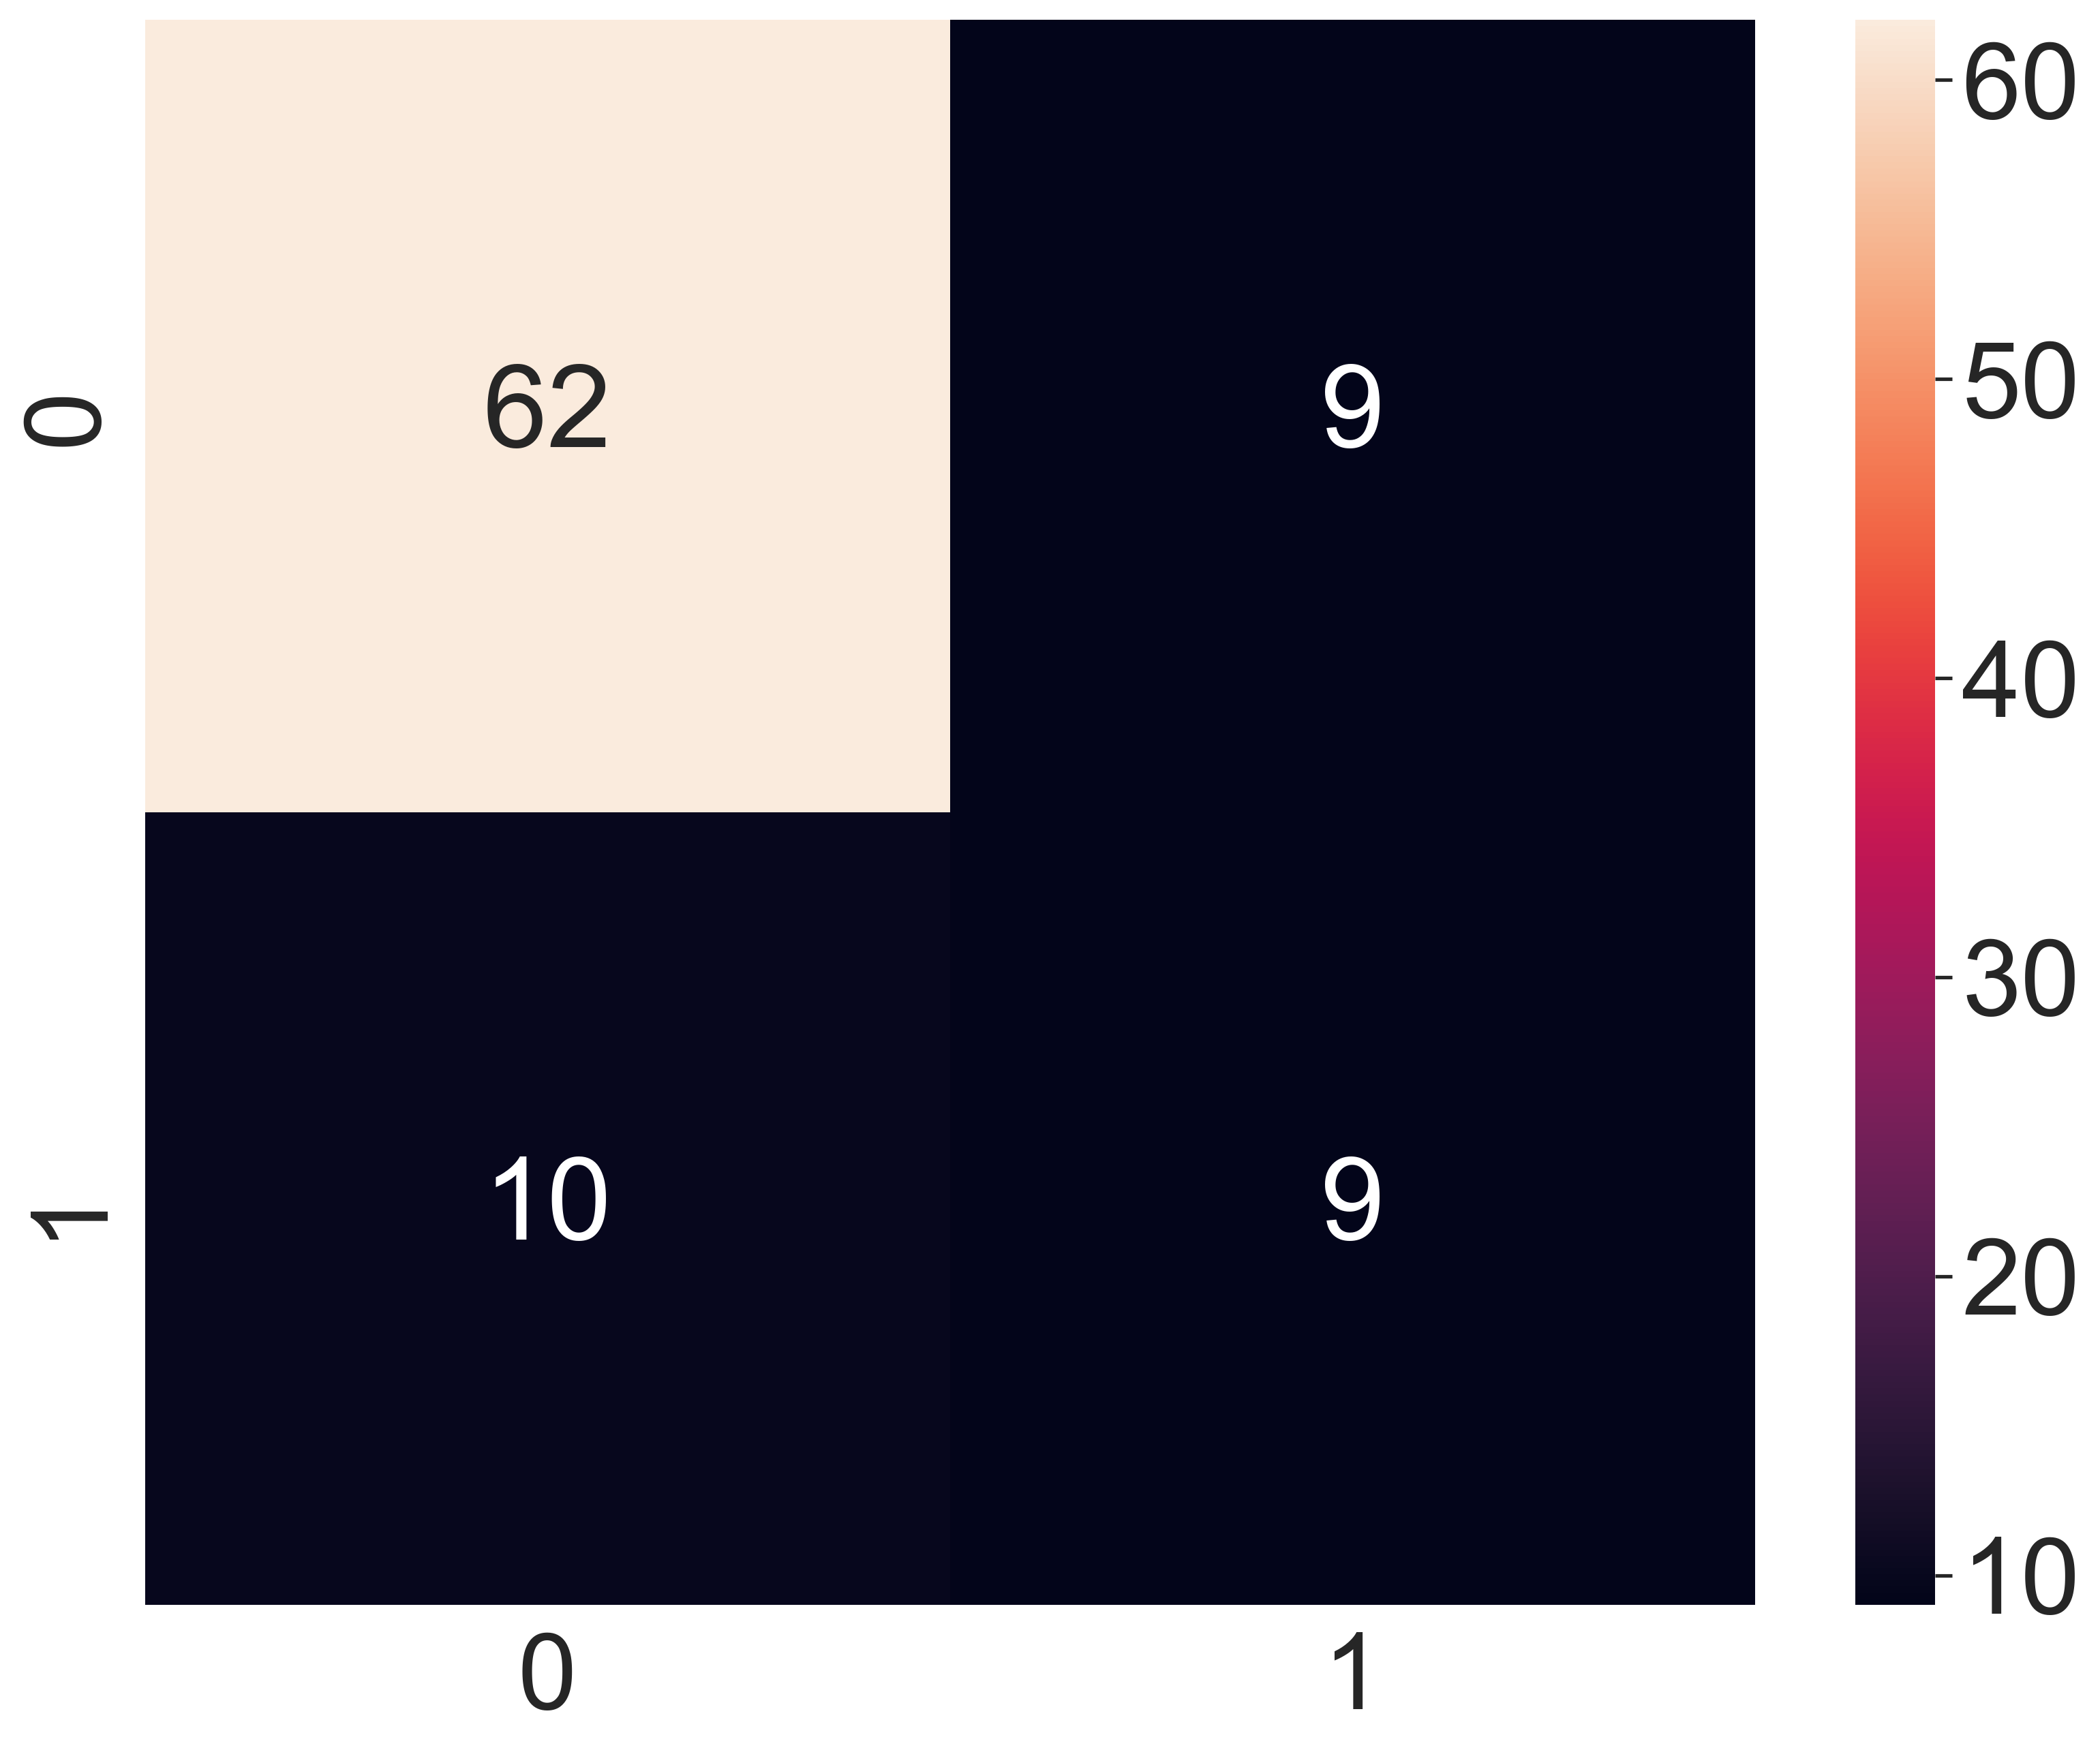

In [98]:
model = GradientBoostingClassifier(max_depth=5, subsample=0.8)
evaluate_model(model, x_t, y_t, X_test, y_test)

### ComBat

In [99]:
x_t_c, y_t_c = create_validate_model(X_test, y_test, X_train_com , y_train.loc[X_train_pre_com.index], False)

2023-04-20 12:00:39.781482: processing dataset: diagnosis


2023-04-20 12:00:50,341:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-04-20 12:00:50,342:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_bus', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
GradientBoostingClassifier() 0.7271666666666665
RandomForestClassifier() 0.6931666666666667
SVC() 0.6435000000000001
DecisionTreeClassifier() 0.6481666666666667
MLPClassifier() 0.6268333333333334
GradientBoostingClassifier()


In [100]:
param_grid = {'bootstrap': [True, False],
                'max_depth': [3, 4, 10, 15],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10],
             }
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=0)
grid.fit(x_t_c, y_t_c)
print(grid.best_estimator_)


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=5)


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7555555555555555
0.536693847294292
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        71
         1.0       0.33      0.16      0.21        19

    accuracy                           0.76        90
   macro avg       0.57      0.54      0.53        90
weighted avg       0.70      0.76      0.72        90



RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=5)

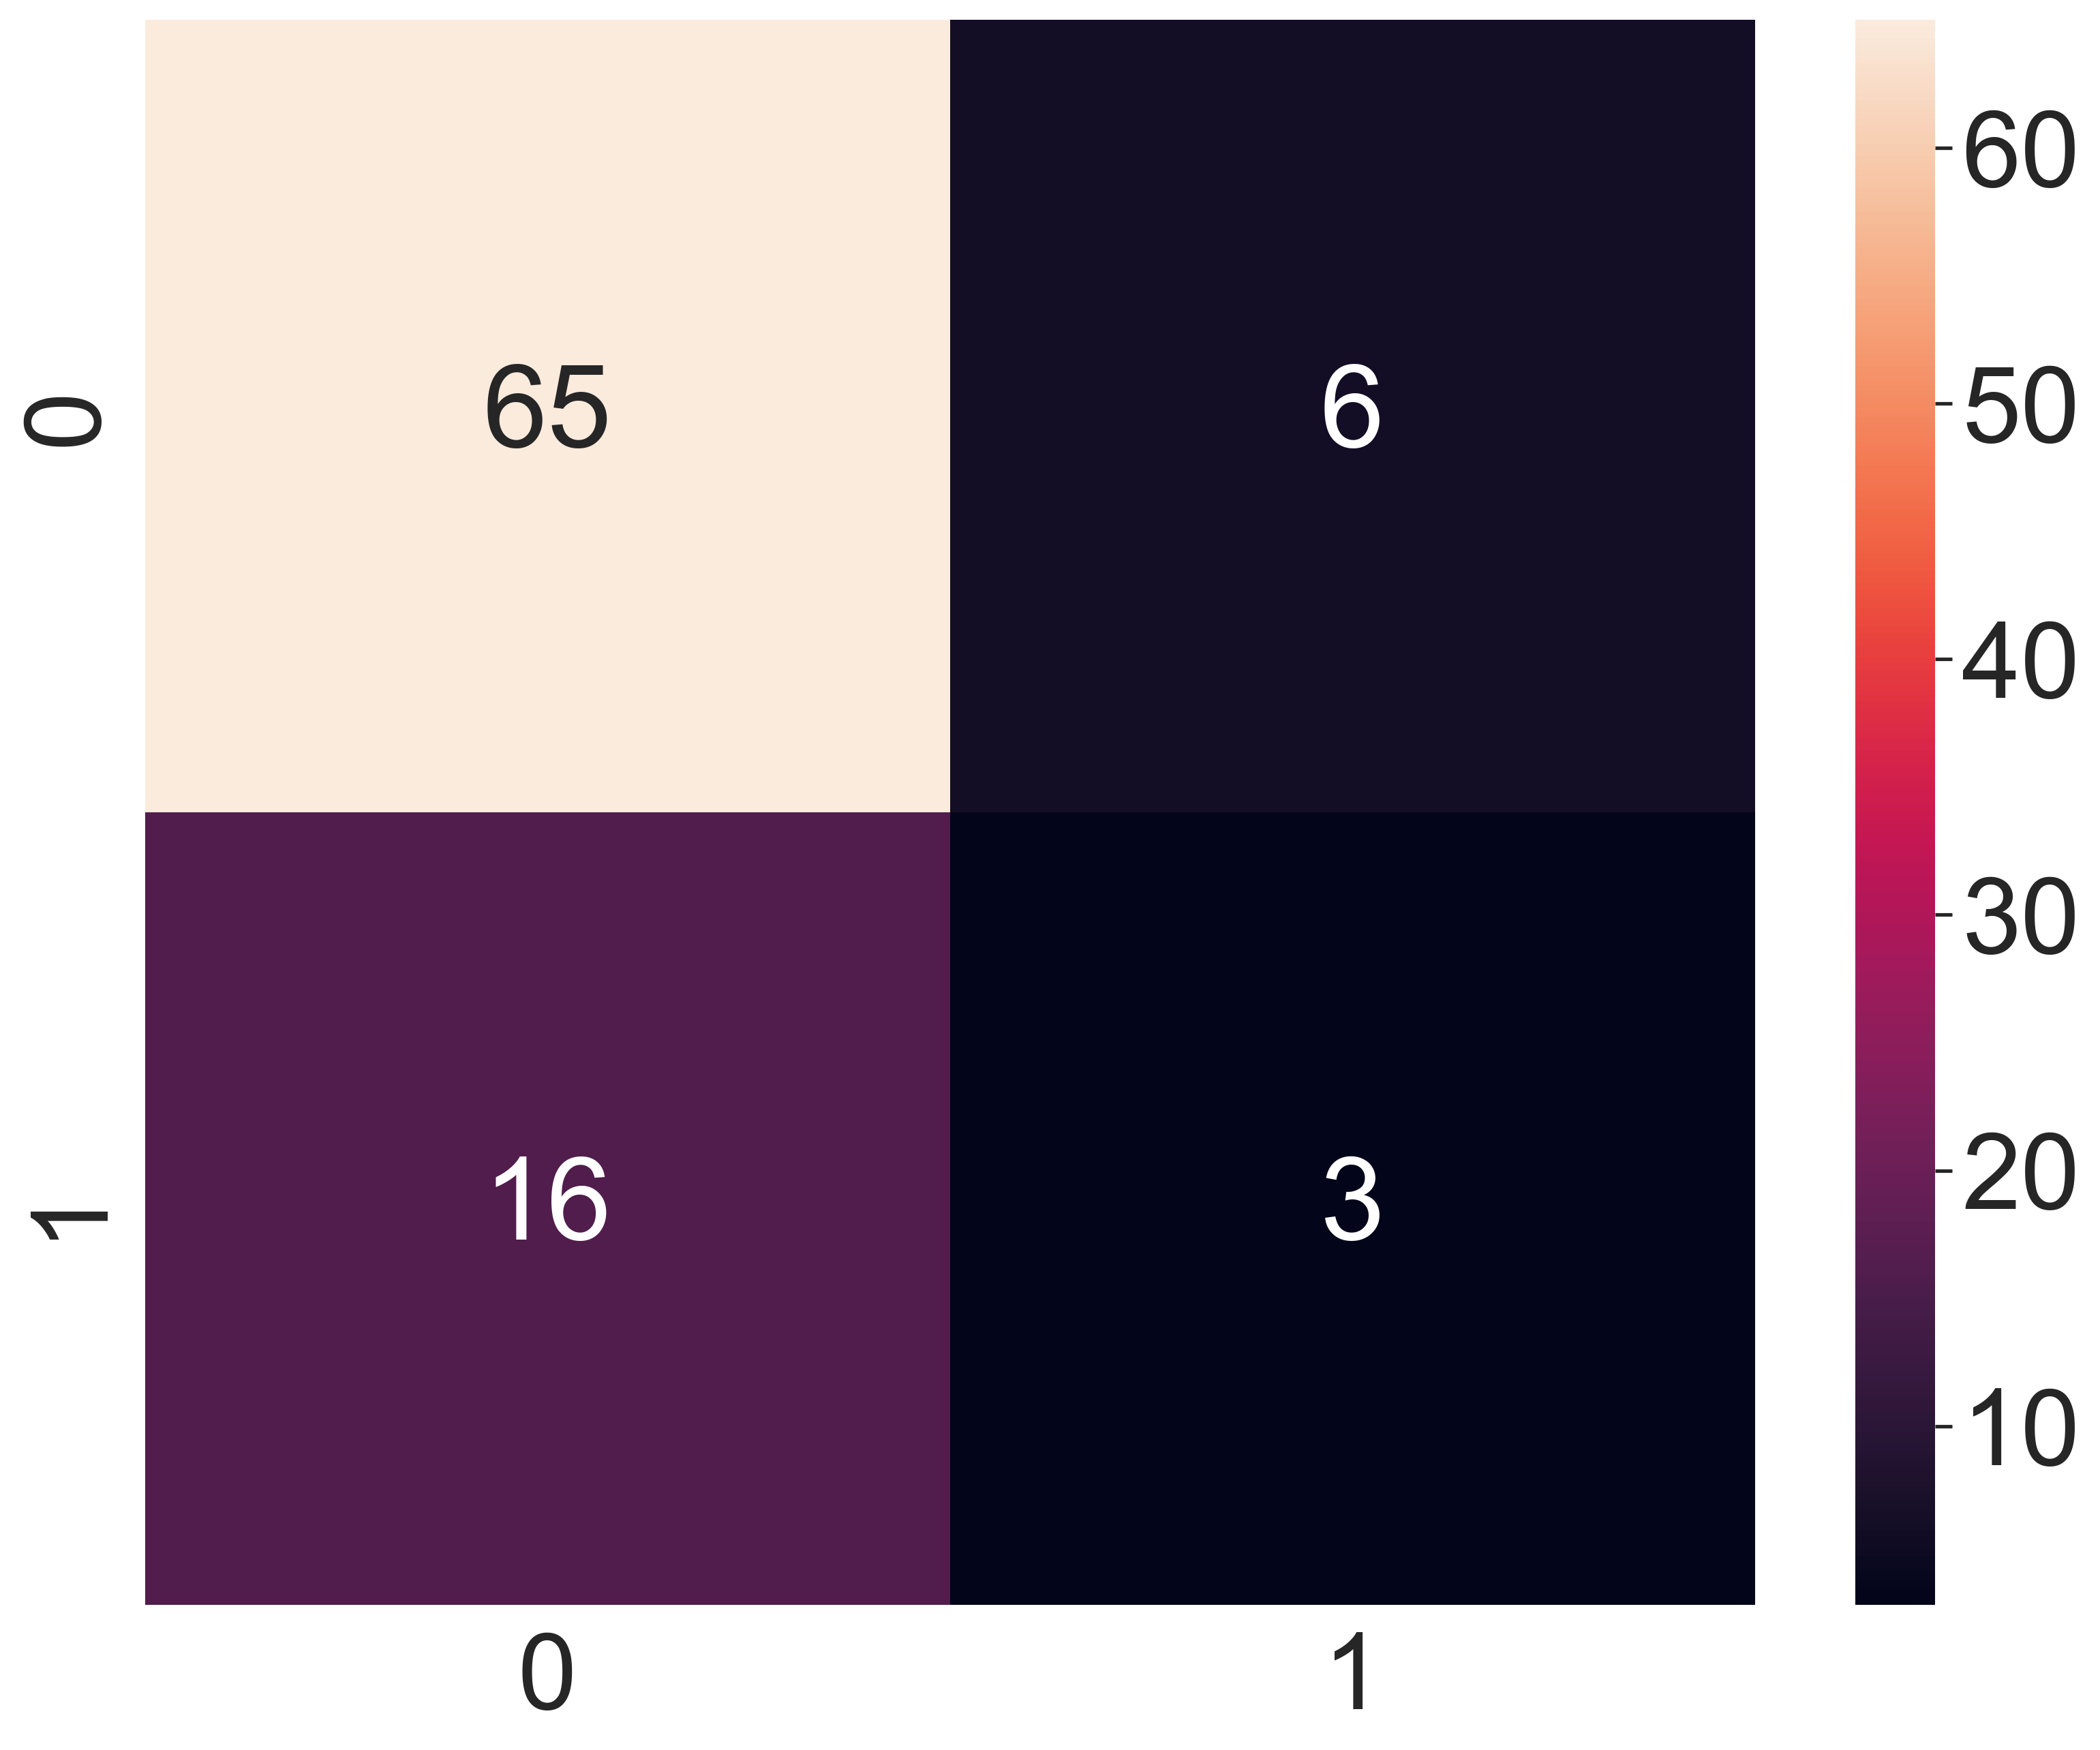

In [102]:
model_cb = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=5)
evaluate_model(model_cb, x_t_c, y_t_c, X_test, y_test)

### ComBat-GAM

In [147]:
x_t_cg, y_t_cg = create_validate_model(X_test, y_test, X_train_cbg , y_train.loc[X_train_pre_cbg.index], False)

2023-04-17 12:10:54.749852: processing dataset: diagnosis


2023-04-17 12:11:06,499:INFO:polynom_fit_SMOTE_star: Running sampling via ('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
2023-04-17 12:11:06,501:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_star', "{'proportion': 0.25, 'topology': 'star', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_star'}")
GradientBoostingClassifier() 0.8394999999999999
RandomForestClassifier() 0.7903333333333334
SVC() 0.661
DecisionTreeClassifier() 0.6795000000000001
MLPClassifier() 0.6255
GradientBoostingClassifier()


In [148]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth":[3,5],
    "subsample":[0.8, 1.0],
    }

grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True,verbose=0)
grid.fit(x_t_cg, y_t_cg)
print(grid.best_estimator_)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, subsample=0.8)


0.7222222222222222
0.520703933747412


C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


GradientBoostingClassifier()

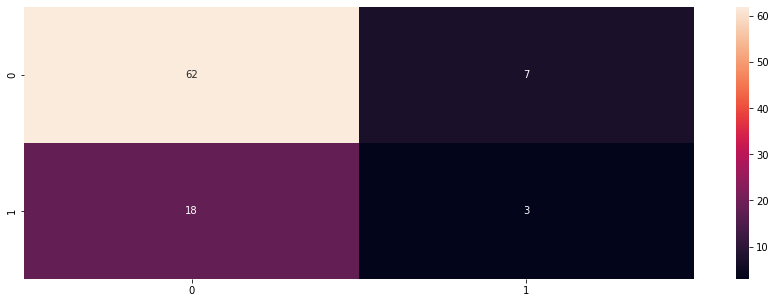

In [178]:
model_cbg = GradientBoostingClassifier()
evaluate_model(model_cbg, x_t_cg, y_t_cg, X_test, y_test)

### CovBat

In [103]:
x_t_cv, y_t_cv = create_validate_model(X_test, y_test, X_train_cov , y_train.loc[X_train_pre_cov.index], False)

2023-04-20 12:03:57.258772: processing dataset: diagnosis


2023-04-20 12:04:02,918:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-04-20 12:04:02,919:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE'}")


('polynom_fit_SMOTE_bus', "{'proportion': 0.5, 'topology': 'bus', 'random_state': None, 'class_name': 'polynom_fit_SMOTE_bus'}")
GradientBoostingClassifier() 0.7761666666666668
RandomForestClassifier() 0.7508333333333332
SVC() 0.6808333333333334
DecisionTreeClassifier() 0.7431666666666666
MLPClassifier() 0.6518333333333334
GradientBoostingClassifier()


In [104]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth":[3,5],
    "subsample":[0.8, 1.0],
    }

grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True,verbose=0)
grid.fit(x_t_cv, y_t_cv)
print(grid.best_estimator_)

GradientBoostingClassifier(learning_rate=0.2, subsample=0.8)


0.7
0.5207561156412157
              precision    recall  f1-score   support

         0.0       0.80      0.83      0.81        71
         1.0       0.25      0.21      0.23        19

    accuracy                           0.70        90
   macro avg       0.52      0.52      0.52        90
weighted avg       0.68      0.70      0.69        90



C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


GradientBoostingClassifier(learning_rate=0.2, subsample=0.8)

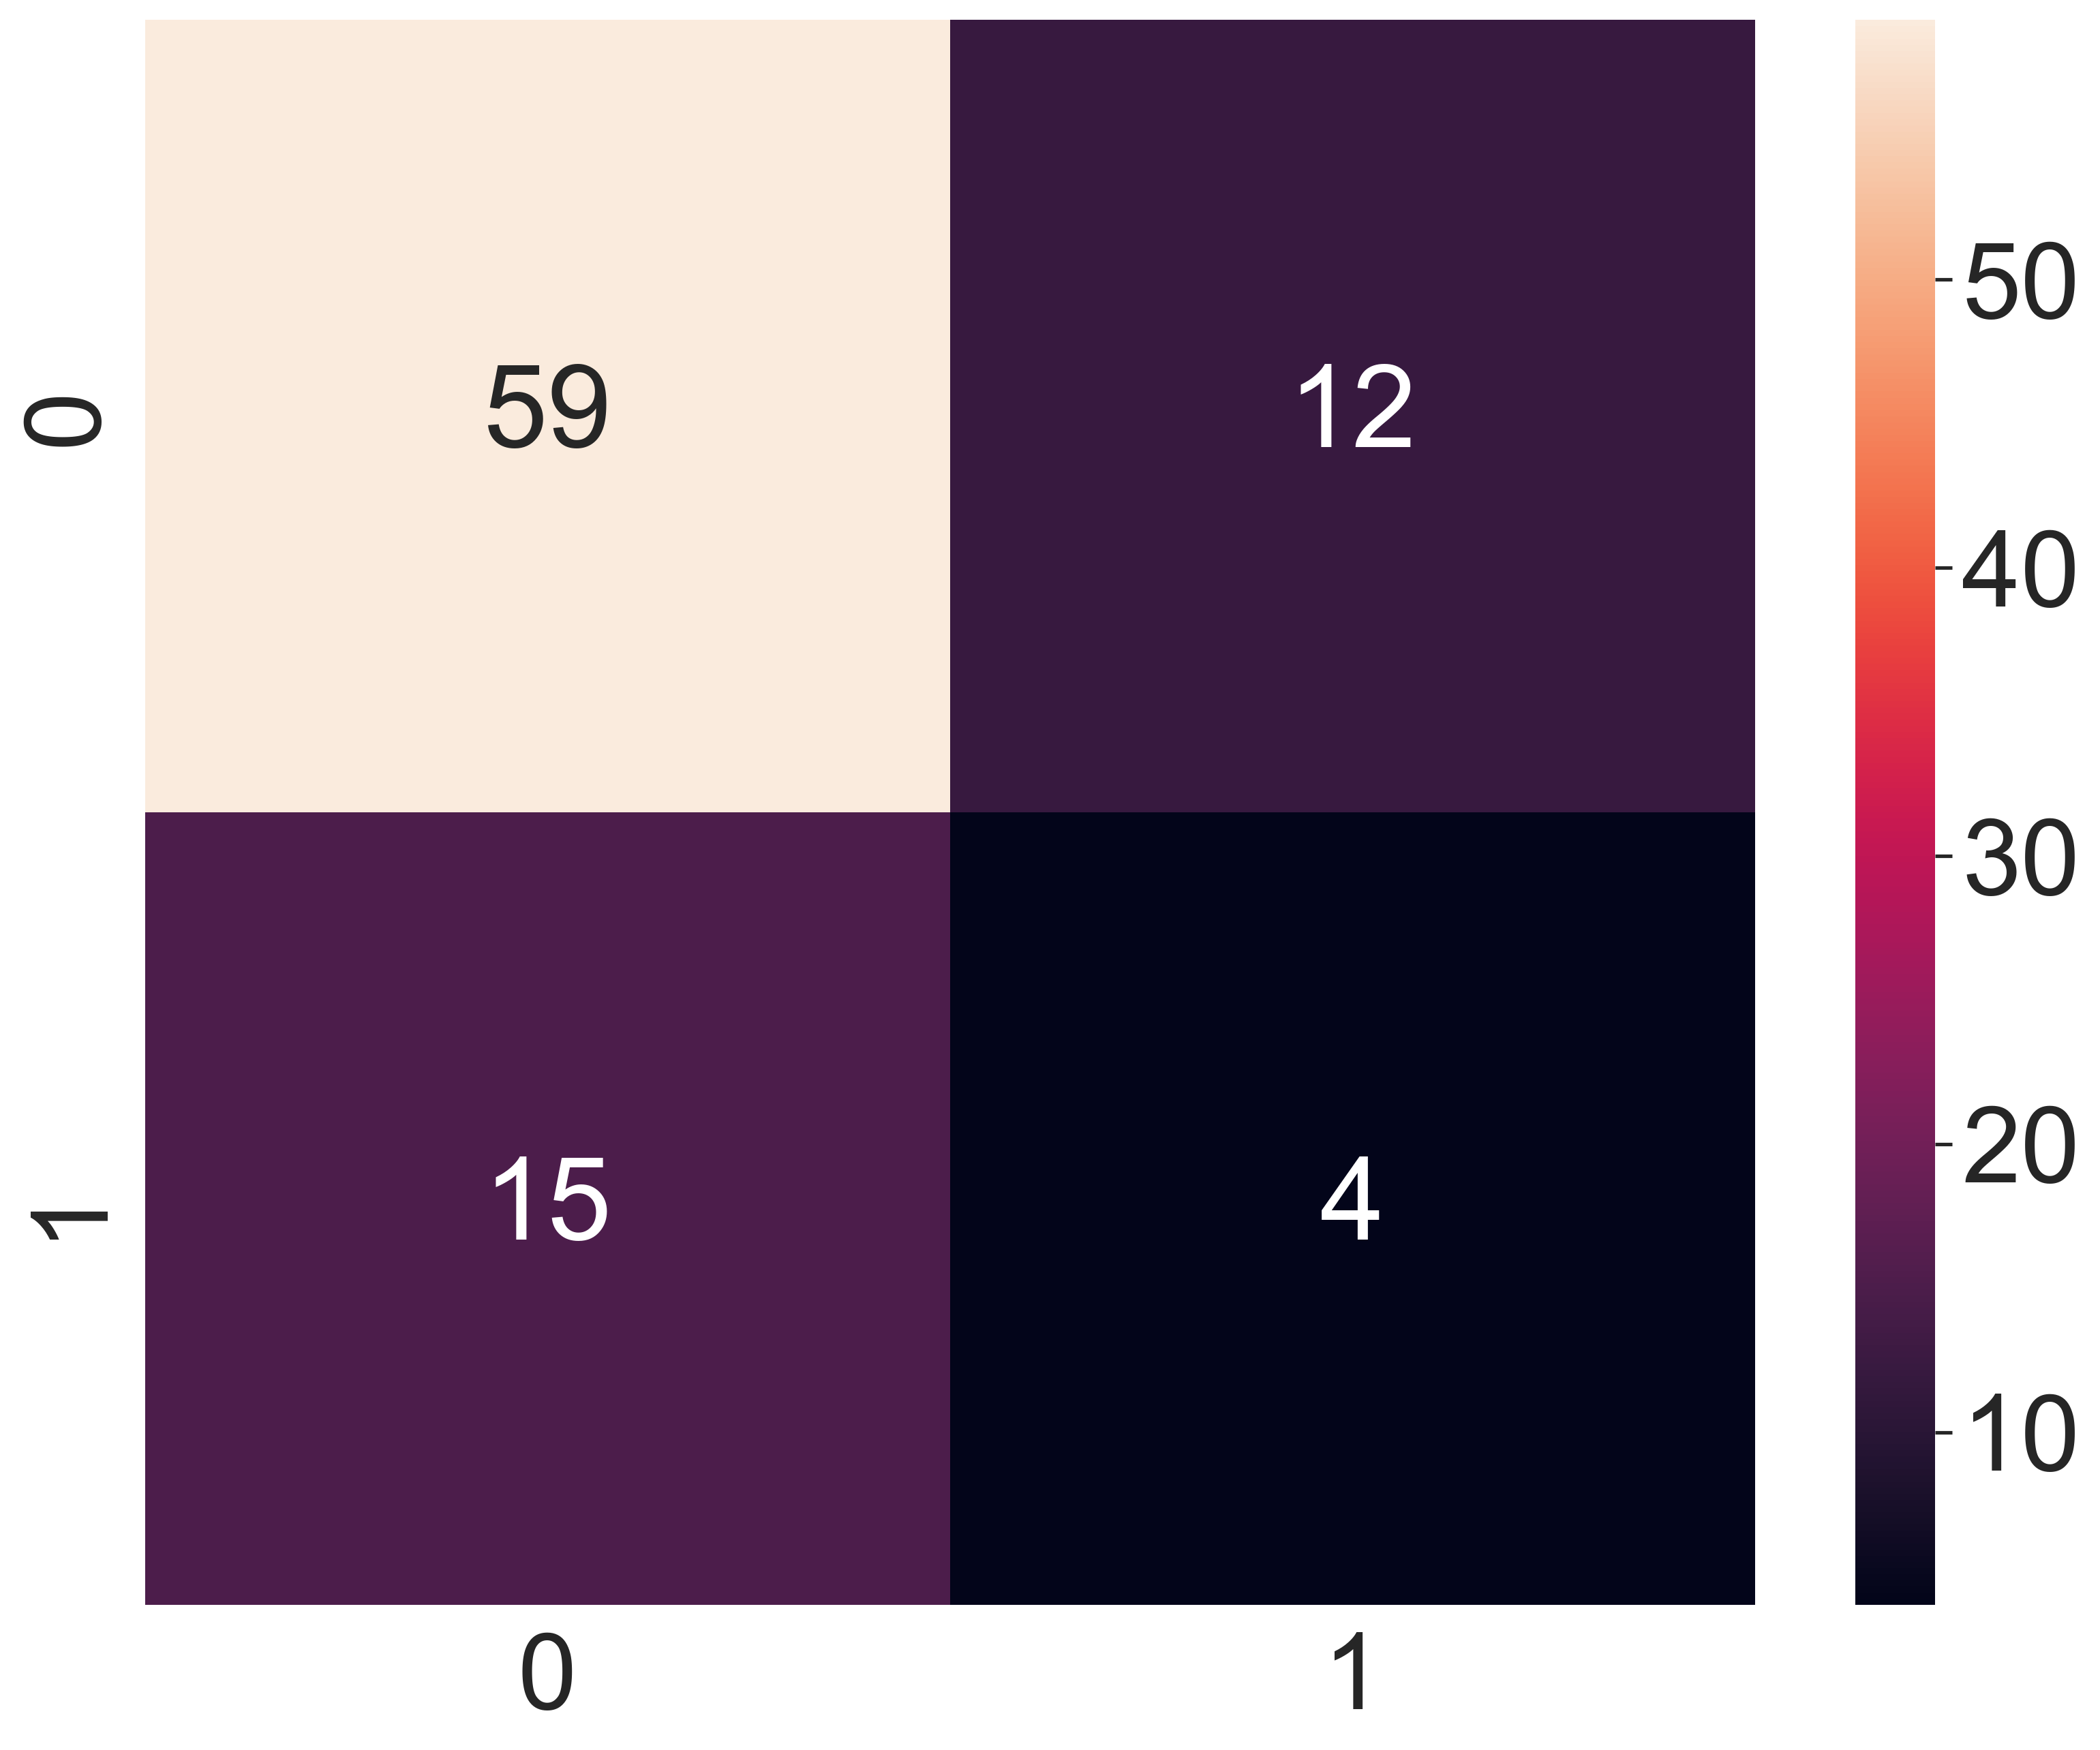

In [105]:
model_cov = GradientBoostingClassifier(learning_rate=0.2, subsample=0.8)
evaluate_model(model_cov, x_t_cv, y_t_cv, X_test, y_test)

### NeuroHarmony


In [ ]:
y_train_nh = x_train_harmonized['DIAGNOSIS']
x_train_harmonized.drop('DIAGNOSIS', inplace=True, axis=1)

In [ ]:
x_train_harmonized.drop(QMs+covariates, inplace=True, axis=1)

In [ ]:
x_t, y_t = create_validate_model(x_train_harmonized, y_train_nh, True)

In [ ]:
model_nh = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=6)
evaluate_model(model_nh, x_train_harmonized, y_train_nh, X_test, y_test)

### Analysis

Feature importances:

Text(0, 0.5, 'Feature Importance Score')

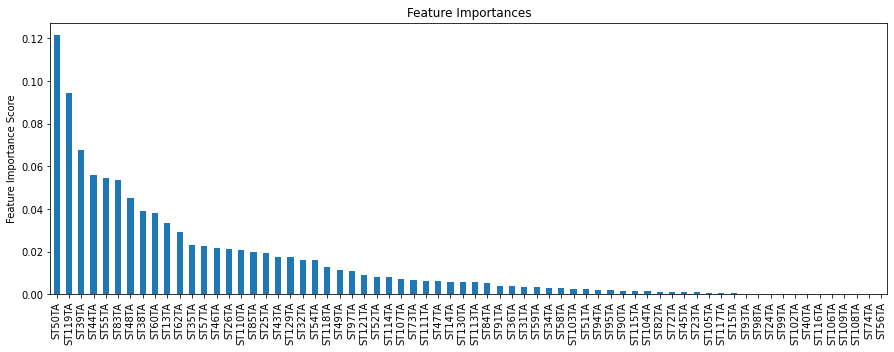

In [190]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
feat_imp = pd.Series(model_cbg.feature_importances_, X_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Text(0, 0.5, 'Feature Importance Score')

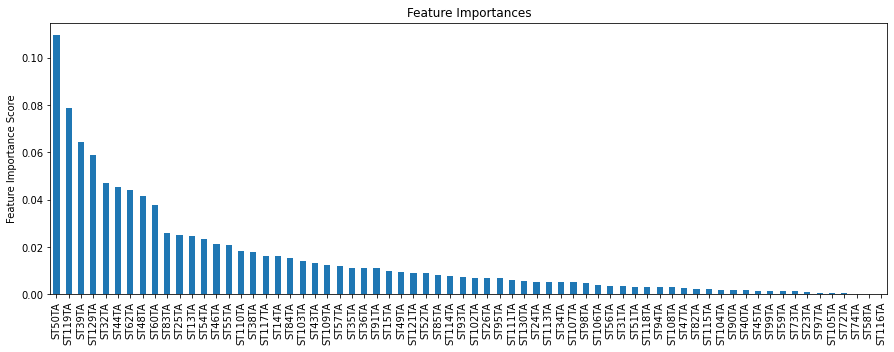

In [191]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
feat_imp = pd.Series(model.feature_importances_, X_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [197]:
unharmonised_importance = pd.Series(model.feature_importances_, X_test.columns)
cbg_importance = pd.Series(model_cbg.feature_importances_, X_test.columns)

In [199]:
from utils import DKDict
import ggseg

paracentral_right


Roc Curves:

C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
C:\Users\vince\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


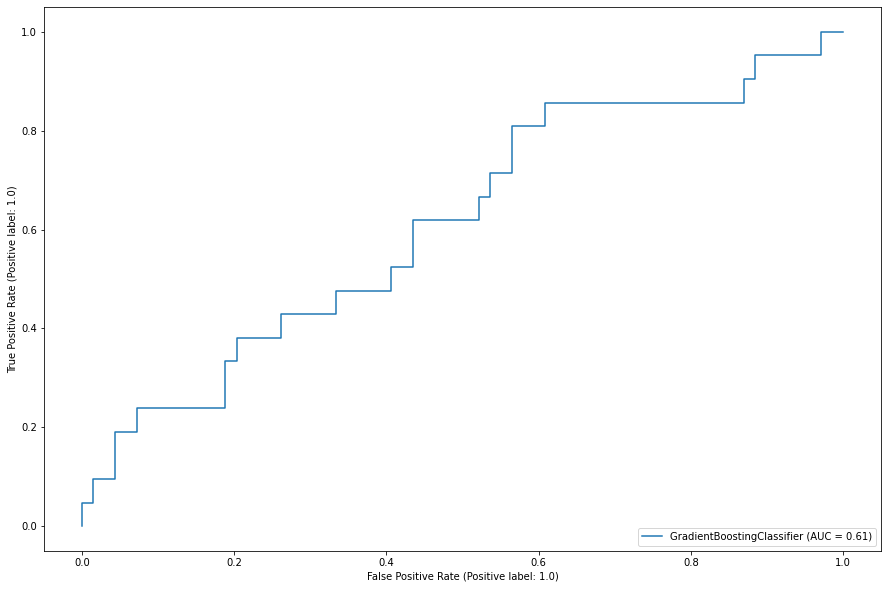

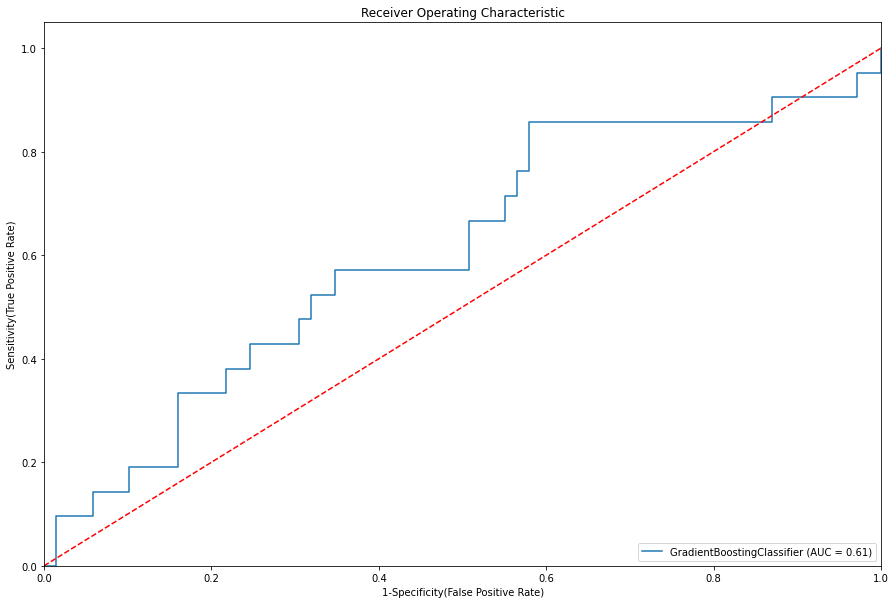

In [195]:

from sklearn.metrics import RocCurveDisplay
plt.rcParams['figure.figsize'] = [15, 10]
#models = [model, model_cov]
svc_disp1 = RocCurveDisplay.from_estimator(model, X_test, y_test)
svc_disp2 = RocCurveDisplay.from_estimator(model_cbg, X_test, y_test)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display


McNemar test:

In [ ]:
# McNemar's test
y_pred_unharm = model.predict(X_test)
y_pred_cbg = model_cbg.predict(X_test)

In [ ]:
correct_cbg = y_pred_cbg == y_test
correct_uh = y_pred_unharm== y_test

both_correct = (correct_cbg & correct_uh)
both_correct = len(both_correct[both_correct == True])

uh_correct = (correct_uh & ~correct_cbg)
uh_correct = len(uh_correct[uh_correct == True])

cbg_correct = (~correct_uh & correct_cbg)
cbg_correct = len(cbg_correct[cbg_correct == True])

none_correct = (~correct_uh & ~correct_cbg)
none_correct = len(none_correct[none_correct == True])


data = [[both_correct, cbg_correct],
         [uh_correct, none_correct]]

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar


threshold = 3.841 
significance_value = 0.05


# McNemar's Test with the continuity correction
test = mcnemar(data, exact=False, correction=True)

if test.pvalue < significance_value:
  print("Reject Null hypotesis")
else:
  print("Fail to reject Null hypotesis")
